In [ ]:
"""
Purpose: Applying Condensed Form of GMM pipeline
where just have to specify if want normalization 
or pca run in preprocessing phase

"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import dimensionality_reduction_utils as dr
import clustering_utils as cl
dr = reload(dr)
cl = reload(cl)
import pandas_utils as pu

from sklearn.preprocessing import StandardScaler
import time
from collections import Counter
import copy
np.set_printoptions(suppress=True)

In [3]:
from sklearn import mixture
import gmm

# Importing the Data

In [4]:
df = pd.read_pickle("neuron_dendrite_path_data")
df_filtered = pu.filter_away_nan_rows(df)

In [100]:
for j,c in enumerate(df_filtered.columns[6:]):
    print(f"{j+1}) {c}")

1) n0_width_median_mesh_center
2) n0_width_no_spine_median_mesh_center
3) n0_n_spines
4) n0_total_spine_volume
5) n0_spine_volume_median
6) n0_spine_volume_density
7) n0_skeletal_length
8) n0_parent_angle
9) n0_sibling_angle
10) n1_width_median_mesh_center
11) n1_width_no_spine_median_mesh_center
12) n1_n_spines
13) n1_total_spine_volume
14) n1_spine_volume_median
15) n1_spine_volume_density
16) n1_skeletal_length
17) n1_parent_angle
18) n1_sibling_angle


# Get the distribution of the limb starts

Text(0.5, 1.0, 'Soma Angle Distribution ')

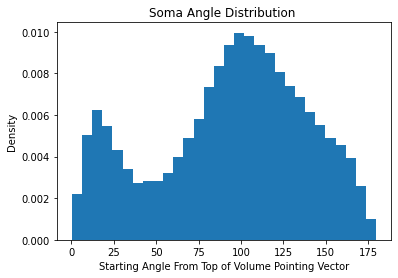

In [96]:
fig,ax = plt.subplots(1,1)
soma_angles =df_filtered[::4]["soma_angle"].to_numpy()

ax.hist(soma_angles,bins=30,density=True)
ax.set_xlabel("Starting Angle From Top of Volume Pointing Vector")
ax.set_ylabel("Density")
ax.set_title("Soma Angle Distribution ")

# Creating Train and Test datasets

In [6]:
def indices_of_soma_angle(df_curr,angle_interval):
    return np.where((df_curr["soma_angle"]>=angle_interval[0]) & 
           (df_curr["soma_angle"]<=angle_interval[-1]))[0]

In [7]:
basal_indices = indices_of_soma_angle(df_filtered,[100,115])
axon_indices = indices_of_soma_angle(df_filtered,[165,180])
apical_indices = indices_of_soma_angle(df_filtered,[0,20])

print(f"# basal paths = {len(basal_indices)}\n",
     f"# axon paths = {len(axon_indices)}\n",
     f"# apical paths = {len(apical_indices)}\n")

# basal paths = 39892
 # axon paths = 8785
 # apical paths = 25478



In [8]:
# picking 10000 of data randomly to test on
random_N = 8000

basal_indices_random =  basal_indices[np.random.choice(np.arange(len(basal_indices)),size=random_N,replace=False)]
axon_indices_random =  axon_indices[np.random.choice(np.arange(len(axon_indices)),size=random_N,replace=False)]
apical_indices_random =  apical_indices[np.random.choice(np.arange(len(apical_indices)),size=random_N,replace=False)]

print(f"After Picking a Random {random_N} subset of paths:\n"
      f"# basal paths = {len(basal_indices_random)}\n",
     f"# axon paths = {len(axon_indices_random)}\n",
     f"# apical paths = {len(apical_indices_random)}\n")

After Picking a Random 8000 subset of paths:
# basal paths = 8000
 # axon paths = 8000
 # apical paths = 8000



In [95]:
len(columns_picked)

18

In [10]:
columns_picked = df_filtered.columns[6:].to_numpy()
columns_picked

array(['n0_width_median_mesh_center',
       'n0_width_no_spine_median_mesh_center', 'n0_n_spines',
       'n0_total_spine_volume', 'n0_spine_volume_median',
       'n0_spine_volume_density', 'n0_skeletal_length', 'n0_parent_angle',
       'n0_sibling_angle', 'n1_width_median_mesh_center',
       'n1_width_no_spine_median_mesh_center', 'n1_n_spines',
       'n1_total_spine_volume', 'n1_spine_volume_median',
       'n1_spine_volume_density', 'n1_skeletal_length', 'n1_parent_angle',
       'n1_sibling_angle'], dtype=object)

# Looking at the different statistical projections

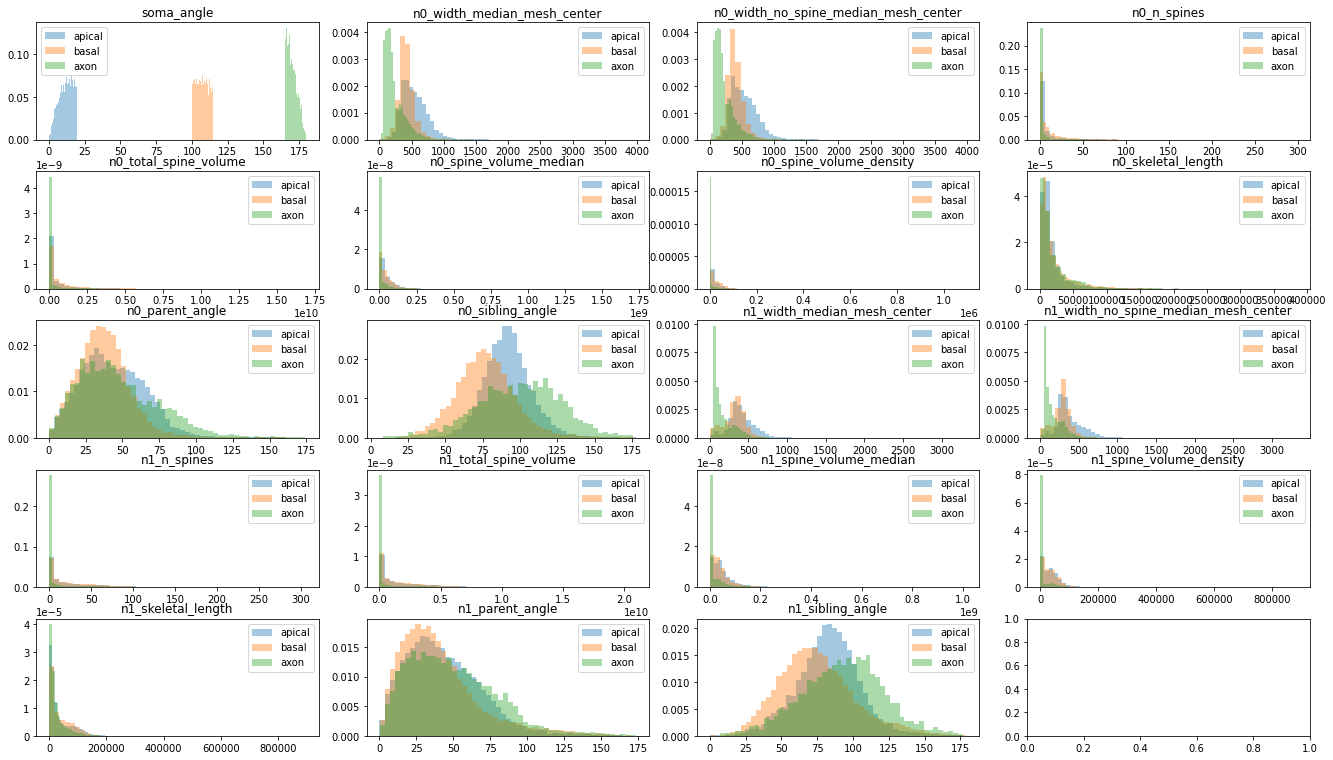

In [12]:
def plot_table_histograms(tables_to_plot,tables_labels,fig_title=None):
    curr_table = apical_table

    fig,axes = plt.subplots(5,4)
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    
    if not fig_title is None:
        fig.title(fig_title)

    
    for j,col_title in enumerate(curr_table):
        row = np.floor(j/4).astype("int")
        column = j - row*4
        ax = axes[row,column]
        ax.set_title(col_title)
        
        for curr_table,curr_table_name in zip(tables_to_plot,tables_labels):
            curr_data = curr_table[col_title].to_numpy()
            ax.hist(curr_data,bins=50,label=curr_table_name,alpha=0.4,density=True)
            
        ax.legend()

df_col_restricted = df_filtered[df_filtered.columns[5:]]
apical_table = df_col_restricted.iloc[apical_indices]
basal_table = df_col_restricted.iloc[basal_indices]
axon_table = df_col_restricted.iloc[axon_indices]
plot_table_histograms([apical_table,basal_table,axon_table],["apical","basal","axon"])

# -- GMM Analysis ---

In [44]:
labeled_data_indices = dict(
                     Axon=axon_indices_random,
                     Basal=basal_indices_random,
                     Apical=apical_indices_random
    )

In [15]:
df_col_filtered = df_filtered[df_filtered.columns[6:]]
df_col_filtered

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,192.16,192.16,0,0.000000e+00,0.00,0.00,4891.73,28.43,140.83,328.27,327.31,4,1.846222e+08,50054356.20,2612.59,70666.48,13.53,96.80
1,192.16,192.16,0,0.000000e+00,0.00,0.00,4891.73,28.43,140.83,99.67,99.67,0,0.000000e+00,0.00,0.00,12721.84,84.41,96.80
2,83.79,83.79,0,0.000000e+00,0.00,0.00,6600.36,113.07,140.83,86.33,86.33,0,0.000000e+00,0.00,0.00,5910.65,29.57,31.68
3,83.79,83.79,0,0.000000e+00,0.00,0.00,6600.36,113.07,140.83,63.25,63.25,0,0.000000e+00,0.00,0.00,6464.83,4.32,31.68
4,363.80,363.80,0,0.000000e+00,0.00,0.00,9932.58,36.37,54.68,397.66,317.97,44,2.416440e+09,42964302.31,46091.42,52427.12,18.83,52.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278313,461.64,461.64,0,0.000000e+00,0.00,0.00,1461.31,47.00,114.81,288.77,288.77,6,3.020934e+08,49298399.24,13474.30,22419.97,86.21,99.05
278314,396.01,396.01,2,1.380452e+08,69022624.61,9362.18,14744.99,68.47,114.81,333.88,284.49,25,2.068806e+09,50627595.27,37042.28,55849.85,3.90,58.52
278315,396.01,396.01,2,1.380452e+08,69022624.61,9362.18,14744.99,68.47,114.81,320.84,280.30,26,1.225729e+09,19951175.90,16039.65,76418.71,60.77,58.52
278316,327.06,313.81,23,1.596199e+09,33134671.25,30817.91,51794.51,68.98,61.65,87.42,87.42,0,0.000000e+00,0.00,0.00,5459.70,102.40,111.85


# Part 1: GMM on Un-Nomralized Dataset (Original Basis)

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Restricting to columns : ['n0_width_median_mesh_center', 'n0_skeletal_length', 'n0_parent_angle', 'n0_sibling_angle', 'n1_width_median_mesh_center', 'n1_skeletal_length', 'n1_parent_angle', 'n1_sibling_angle']
# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Convergence status = True
Total time for GMM = 3.4643609523773193


------Working on clusters K=3-----
Convergence status = True
Total time for GMM = 5.136988639831543


------Working on clusters K=4-----
Convergence status = True
Total time for GMM = 15.371966123580933


------Working on clusters K=5-----
Convergence status = True
Total time for GMM = 21.12192940711975


------Working on clusters K=6-----
Convergence status = True
Total time for GMM = 15.10989260673523
# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Working on Advance

,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,448.151440,12729.571673,36.940855,79.468846,366.588398,50195.711227,35.586218,70.598966
1,373.169568,34638.627401,44.736034,87.465370,239.030935,16452.916780,53.397673,91.287985




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,5455,2545
0,hard,Axon,2,1671,6329
1,hard,Basal,2,5484,2516




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,0,0.681875,2,0.366057
0,Axon,hard,2,1,0.791125,2,0.467278
1,Basal,hard,2,0,0.685500,2,0.367591




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,437.404754,30803.041034,41.237341,83.563630,262.885335,7006.933376,63.359308,88.797566
1,305.579710,34357.602879,46.202294,87.966674,254.849106,40329.912630,32.536948,84.559843
2,464.716663,10291.465465,36.389711,79.576951,372.771391,50030.285616,37.279669,70.995182




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,2285,1009,4706
0,hard,Axon,3,1895,4945,1160
1,hard,Basal,3,1814,1495,4691




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,2,0.588250,2,0.388193
0,Axon,hard,3,1,0.618125,2,0.501161
1,Basal,hard,3,2,0.586375,2,0.366684




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,336.637067,39742.784765,44.264428,84.216839,288.489247,41812.806605,31.323704,84.639974
1,445.160522,11523.477088,36.535634,78.480926,356.564519,59663.163174,38.075913,67.546563
2,299.545359,38098.175997,43.099323,84.528978,95.173918,6416.051996,77.669546,93.308278
3,539.693303,8949.560021,40.062643,87.550075,428.093436,10638.792487,37.812190,83.495678




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,1088,3010,492,3410
0,hard,Axon,4,2929,821,3171,1079
1,hard,Basal,4,1462,3947,1177,1414




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,3,0.426250,2,0.425095
0,Axon,hard,4,2,0.396375,3,0.490903
1,Basal,hard,4,1,0.493375,3,0.377248




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,508.958280,8838.712173,35.730781,81.667486,412.949397,12077.880078,32.850302,77.993311
1,523.200395,10173.801633,59.214318,106.345991,380.835541,24532.365657,54.882480,89.583223
2,299.967074,36113.571705,42.820928,84.277567,95.942061,6238.452777,77.001285,93.468588
3,338.511687,43930.786558,41.309710,80.965611,291.618768,41113.403332,28.038282,85.751737
4,432.520749,12982.351834,37.270584,78.731464,349.537337,70307.203598,39.694101,66.074492




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,3288,786,503,881,2542
0,hard,Axon,5,797,1032,3307,2225,639
1,hard,Basal,5,2165,269,1191,1329,3046




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,0,0.411000,3,0.411134
0,Axon,hard,5,2,0.413375,3,0.497574
1,Basal,hard,5,4,0.380750,3,0.369562




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,518.391665,8466.120654,35.948321,82.707801,414.994128,11879.333838,33.741264,78.428713
1,541.753924,13376.171141,58.883211,105.158810,397.183303,50838.848030,52.296535,87.484492
2,371.336510,39035.825126,39.125084,74.007475,112.035399,4556.138433,82.654709,90.475645
3,429.481565,12354.674348,37.316936,78.726119,349.324229,68971.166116,39.875312,66.223242
4,188.216338,35069.094077,49.130331,100.096436,100.655372,13069.337115,58.495395,99.154528
5,371.809985,41295.015625,39.508722,76.875341,331.755013,41783.090360,23.677051,80.644359




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,3408,723,474,2414,105,876
0,hard,Axon,6,830,773,368,622,4603,804
1,hard,Basal,6,2099,267,1051,2953,334,1296




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,0,0.426000,3,0.435131
0,Axon,hard,6,4,0.575375,4,0.625401
1,Basal,hard,6,3,0.369125,4,0.420219


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


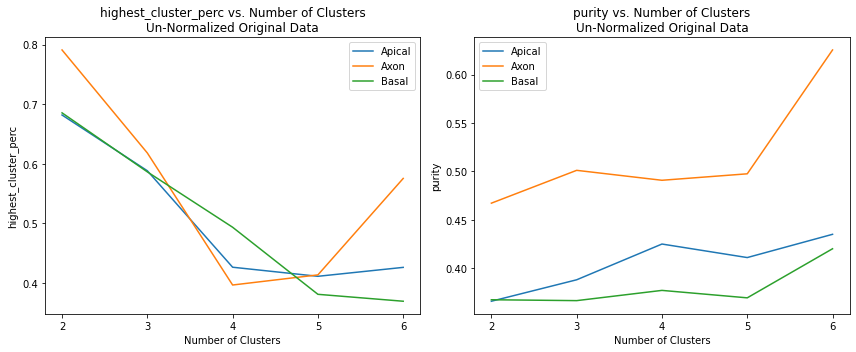

In [20]:
gmm = reload(gmm)
import pandas_utils as pu
pu = reload(pu)

unscaled_columns_picked =[k for k in df_col_filtered.columns if "spine" not in k]


gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Un-Normalized Original Data",
                 columns_picked = unscaled_columns_picked,
                 possible_K = [2,3,4,5,6],
                 apply_normalization=False,
                 apply_pca=False,
                 
                )

# Part 2: GMM on Normalized Dataset (Original Basis)

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 5.61519193649292


------Working on clusters K=3-----
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 32.42280435562134


------Working on clusters K=4-----
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 33.82495164871216


------Working on clusters K=5-----
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 42.219807147979736


------Working on clusters K=6-----
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 75.61059165000916
# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Wo

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,328.878071,309.408062,12.000564,8.525606e+08,3.203158e+07,20160.464178,29835.724101,43.846735,86.907356,170.946313,170.942616,0.000901,6.464174e+04,3.123192e+03,3.977933,11171.798131,61.802170,91.297343
1,454.013634,437.483605,7.689770,5.626005e+08,4.669046e+07,22553.813663,18238.242682,38.567284,80.993113,373.605147,329.945271,26.524586,1.731995e+09,5.040209e+07,38678.141986,46871.348534,35.055117,73.951261




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,1323,6677
0,hard,Axon,2,6057,1943
1,hard,Basal,2,1880,6120




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,1,0.834625,1,0.401700
0,Axon,hard,2,0,0.757125,2,0.527254
1,Basal,hard,2,1,0.765000,2,0.365336




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,482.549384,482.398098,0.423357,5.822123e+06,4.495964e+06,661.152218,7304.789981,39.979413,84.822543,376.694572,348.063220,20.916111,1.390280e+09,5.026016e+07,29996.095398,45049.164574,39.679715,77.062540
1,323.746245,303.590652,12.429962,8.831291e+08,3.287339e+07,20808.780491,30552.557822,43.600767,86.460375,167.676694,167.672961,0.000812,6.670475e+04,2.879006e+03,4.067651,9578.351005,62.427911,91.488477
2,440.073024,415.728727,11.149336,8.281595e+08,6.687379e+07,33016.665777,23513.715051,38.121847,79.475375,369.561340,319.373595,28.738642,1.864374e+09,4.937868e+07,42157.200247,47925.124597,32.973151,72.669552




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,2584,1269,4147
0,hard,Axon,3,1181,5729,1090
1,hard,Basal,3,1919,1853,4228




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,2,0.518375,2,0.396703
0,Axon,hard,3,1,0.716125,2,0.509891
1,Basal,hard,3,2,0.528500,3,0.365557




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,381.468013,381.468013,1.385558e-13,1.037121e-05,5.736947e-07,3.310561e-10,7938.472947,43.962343,91.372264,292.462751,275.527783,12.602202,8.509167e+08,3.126868e+07,18254.534662,33072.666907,44.220437,83.372140
1,376.223940,345.465037,1.909946e+01,1.357125e+09,5.031330e+07,3.178760e+04,41379.496088,39.975994,78.574390,170.973230,170.967475,0.001195,1.027349e+05,4.336771e+03,6.247734,7336.076468,68.315379,90.582100
2,457.826102,447.914774,4.082386e+00,2.781637e+08,5.595650e+07,1.945589e+04,12954.924382,38.392549,80.710350,376.502519,331.372571,29.414310,1.922728e+09,4.878727e+07,38428.287632,49541.658941,36.146278,71.710304
3,428.417315,383.083280,2.213176e+01,1.662506e+09,6.825906e+07,4.913796e+04,40025.601262,38.139276,78.370435,363.498526,310.180164,24.722348,1.568618e+09,5.133201e+07,45748.445760,43661.223027,28.895220,76.140124




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,1959,987,3967,1087
0,hard,Axon,4,5256,1438,831,475
1,hard,Basal,4,1625,1518,3364,1493




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,2,0.495875,3,0.374506
0,Axon,hard,4,0,0.657000,2,0.475994
1,Basal,hard,4,2,0.420500,3,0.374906




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,413.663622,389.532749,1.076975e+01,8.029125e+08,5.967464e+07,3.206897e+04,22280.757272,38.490214,78.370372,346.579073,288.615330,4.175240e+01,2.614217e+09,3.967893e+07,3.959156e+04,68480.343711,34.176767,69.115942
1,481.098387,428.040970,2.898116e+01,2.191511e+09,7.564920e+07,5.886088e+04,54725.045759,38.836887,81.658052,402.551367,356.984829,1.588896e+01,1.098410e+09,5.563134e+07,4.883559e+04,36966.325077,32.335656,82.267113
2,474.147968,474.147968,2.025047e-13,1.525879e-05,9.313226e-07,4.911271e-10,6375.645585,40.383800,85.934643,372.349194,346.978457,1.878958e+01,1.268599e+09,4.618215e+07,2.714263e+04,42427.341043,39.641264,77.822072
3,313.379345,292.674326,1.295090e+01,9.025453e+08,3.383805e+07,2.066102e+04,31539.914978,43.626318,86.200116,150.798802,150.798802,8.419931e-13,5.602837e-05,1.586974e-06,1.236913e-09,9498.432906,63.714993,91.950384
4,495.952928,487.833260,3.153839e+00,2.102457e+08,5.647893e+07,1.700702e+04,11645.279827,37.934304,82.125354,409.886386,378.145241,9.269481e+00,7.258808e+08,6.307096e+07,3.991013e+04,17460.514333,33.896594,77.020258




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,2167,422,1870,1064,2477
0,hard,Axon,5,635,259,1128,5552,426
1,hard,Basal,5,2800,399,1384,1759,1658




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,4,0.309625,3,0.410194
0,Axon,hard,5,3,0.694000,2,0.518101
1,Basal,hard,5,0,0.350000,4,0.369523




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,312.810960,292.016071,1.300680e+01,9.065090e+08,3.391670e+07,2.074130e+04,31630.090208,43.622296,86.197547,150.026739,150.026739,9.450218e-13,6.008148e-05,1.773238e-06,1.371518e-09,9517.521575,63.787475,91.980953
1,406.129392,362.982321,2.152358e+01,1.607389e+09,6.071652e+07,4.596923e+04,37755.440427,38.425964,77.261068,347.505236,289.434155,3.053454e+01,1.922737e+09,4.139421e+07,4.161025e+04,48214.505317,28.334157,73.082226
2,426.738228,418.723943,3.428218e+00,2.226180e+08,5.665388e+07,1.766694e+04,12080.654525,38.714219,79.866689,347.698094,292.012570,4.589419e+01,2.895419e+09,4.017455e+07,3.831284e+04,78248.751746,39.481468,67.792280
3,505.018349,495.920566,3.359245e+00,2.312611e+08,5.794646e+07,1.824152e+04,11957.242108,37.802330,82.363481,418.026503,389.070950,7.220210e+00,5.864397e+08,6.585782e+07,3.984863e+04,14140.738319,33.149365,77.928817
4,473.437702,473.437702,1.119105e-13,9.536743e-06,5.289912e-07,2.728484e-10,6314.507441,40.369732,85.908552,372.530584,347.223640,1.872740e+01,1.264759e+09,4.603451e+07,2.707598e+04,42219.187388,39.614959,77.789783
5,568.305421,523.597986,1.673211e+01,1.504311e+09,1.002378e+08,7.506335e+04,44402.785421,38.758186,86.278204,479.319080,442.672108,1.599569e+01,1.237496e+09,6.554111e+07,5.698888e+04,47792.540752,40.321327,82.071129




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,1058,973,1578,2295,1865,231
0,hard,Axon,6,5550,419,401,374,1126,130
1,hard,Basal,6,1751,1598,1680,1425,1390,156




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,3,0.286875,4,0.414344
0,Axon,hard,6,0,0.693750,2,0.517984
1,Basal,hard,6,0,0.218875,4,0.372036


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


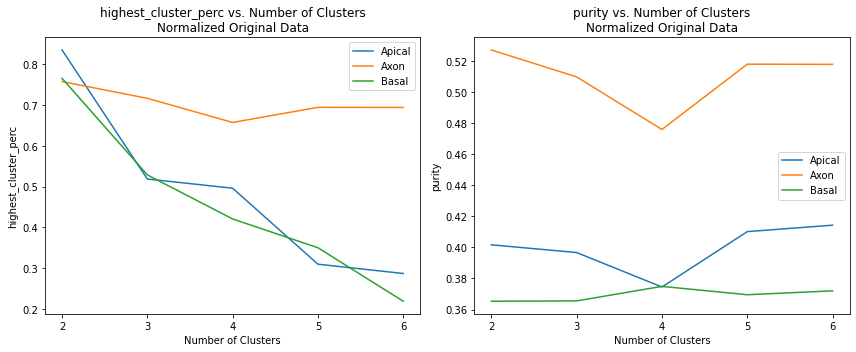

In [22]:
gmm = reload(gmm)
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Normalized Original Data",
                 columns_picked = None,
                 possible_K = [2,3,4,5,6],
                 apply_normalization=True,
                 apply_pca=False,
                 
                )

# Part 3: GMM on PCA Dataset (Full Components)

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
Applying pca with 18 components
n_components = 18
whiten = True
---- Using sklearn method ----


<Figure size 432x288 with 0 Axes>

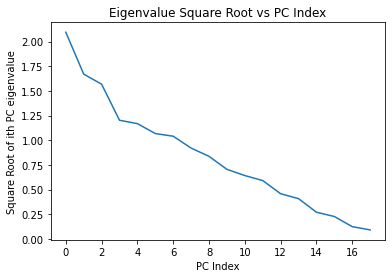

Explained Variance = [0.24358275 0.39851786 0.53504943 0.61538891 0.69121311 0.75457606
 0.81475647 0.86183718 0.90075796 0.92839675 0.95132215 0.97077071
 0.98244248 0.99170941 0.9957869  0.99866557 0.99953143 1.        ]


<Figure size 432x288 with 0 Axes>

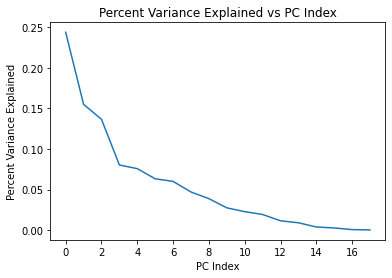

# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 3.194558620452881


------Working on clusters K=3-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 16.368922233581543


------Working on clusters K=4-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 30.465229034423828


------Working on clusters K=5-----
Using mixture model
Errored on gmm for reg_cov = 1e-05
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 80.80589079856873


------Working on clusters K=6-----
Using mixture model
reversing the pca t

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,466.483892,443.567573,11.955902,8.724796e+08,4.684457e+07,25892.172664,22809.236338,38.62059,80.521640,339.922307,316.370987,6.639907,4.940611e+08,4.101510e+07,27176.537684,13728.194228,44.264223,82.011772
1,358.794275,348.127849,5.274940,3.723685e+08,3.712088e+07,16973.095093,20117.645754,41.88184,85.350438,284.740823,244.635897,33.664072,2.124828e+09,2.952803e+07,27873.377726,64217.740616,41.006100,75.278017




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,5280,2720
0,hard,Axon,2,1491,6509
1,hard,Basal,2,4612,3388




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,0,0.660000,2,0.379439
0,Axon,hard,2,1,0.813625,1,0.444154
1,Basal,hard,2,0,0.576500,2,0.347299




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,327.350574,308.211990,11.949283,8.324686e+08,3.133490e+07,19059.384779,29824.739828,43.859153,86.905841,170.218827,170.218827,1.747935e-12,1.134872e-04,3.270805e-06,2.517481e-09,11473.374089,61.805030,91.318284
1,426.996353,385.059396,19.434296,1.503547e+09,7.281008e+07,49536.203503,35542.465260,37.893465,78.320176,364.678171,308.743027,2.769914e+01,1.788558e+09,4.747532e+07,4.554923e+04,44542.044238,29.665474,74.216078
2,467.412297,462.569742,2.230058,1.346333e+08,3.486552e+07,10581.082379,10161.937314,38.881648,82.251989,377.967426,340.102705,2.594304e+01,1.703446e+09,5.171173e+07,3.541800e+04,47737.916589,37.608114,73.836117




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,1309,1457,5234
0,hard,Axon,3,6092,561,1347
1,hard,Basal,3,1875,1969,4156




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,2,0.65425,2,0.408575
0,Axon,hard,3,0,0.76150,2,0.531104
1,Basal,hard,3,2,0.51950,3,0.370010




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,472.997102,472.997102,4.618528e-13,3.314018e-05,2.235174e-06,1.091394e-09,6415.700425,40.306860,85.842118,369.386481,343.723312,1.898610e+01,1.281498e+09,4.686521e+07,2.748928e+04,43090.477902,39.671094,77.759621
1,453.590358,440.934591,5.120726e+00,3.663257e+08,5.759846e+07,2.242895e+04,14428.676019,38.325915,80.421394,375.508844,329.256630,2.896795e+01,1.887714e+09,4.945491e+07,3.923589e+04,48621.986791,35.342833,71.725786
2,432.226136,380.877182,2.634739e+01,1.992538e+09,6.888079e+07,5.363891e+04,46637.149942,38.242065,78.407866,361.922822,309.390482,2.409970e+01,1.527642e+09,4.977495e+07,4.579252e+04,43609.227778,28.615113,77.999708
3,316.803843,296.157698,1.287759e+01,8.976930e+08,3.382203e+07,2.059009e+04,31502.910510,43.671016,86.311147,159.370610,159.370610,7.069900e-13,4.601479e-05,1.303852e-06,1.000444e-09,9428.135597,63.500112,91.902540




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,1822,4300,744,1134
0,hard,Axon,4,1136,917,378,5569
1,hard,Basal,4,1371,3861,987,1781




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,1,0.537500,3,0.402210
0,Axon,hard,4,3,0.696125,2,0.514255
1,Basal,hard,4,1,0.482625,3,0.364015




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,473.704926,473.704926,3.872458e-13,2.777576e-05,1.907349e-06,9.167707e-10,6361.311403,40.234919,85.781774,371.137082,345.386003,1.906731e+01,1.286837e+09,4.678730e+07,2.754165e+04,42833.947669,39.628637,77.697205
1,468.857620,462.760286,2.694627e+00,1.604914e+08,5.359375e+07,1.420614e+04,11059.464683,38.423105,81.411086,381.361600,340.226636,2.731194e+01,1.801271e+09,5.198806e+07,3.801766e+04,47772.994176,37.200131,73.008739
2,410.662327,372.703522,1.776599e+01,1.345344e+09,6.375085e+07,4.409636e+04,32008.228224,38.145224,77.518199,353.785167,296.068119,3.067705e+01,1.943291e+09,4.341463e+07,4.250011e+04,48130.760099,29.163764,72.179826
3,548.774283,507.168691,1.912020e+01,1.545248e+09,9.270669e+07,6.287788e+04,45697.215013,38.907399,85.138564,456.871203,423.457050,1.186381e+01,8.112174e+08,7.005900e+07,5.094119e+04,40118.417722,37.556120,82.025926
4,314.777287,294.217971,1.284997e+01,8.957141e+08,3.366417e+07,2.051978e+04,31331.827316,43.676415,86.284594,153.757017,153.757017,5.329071e-13,3.409386e-05,9.834766e-07,7.494236e-10,9540.888159,63.481618,91.885075




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,1848,3340,1383,338,1091
0,hard,Axon,5,1101,668,474,172,5585
1,hard,Basal,5,1374,2572,2041,244,1769




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,1,0.417500,3,0.408564
0,Axon,hard,5,4,0.698125,2,0.517334
1,Basal,hard,5,1,0.321500,4,0.370030




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,419.005213,404.717582,5.910893e+00,4.320845e+08,6.053772e+07,2.525608e+04,15402.005066,38.618198,79.057570,346.486986,288.392730,4.571486e+01,2.869431e+09,3.976882e+07,3.908788e+04,75185.560022,37.407436,66.558900
1,473.257054,473.257054,1.207923e-13,9.417534e-06,5.289912e-07,2.801244e-10,6319.375263,40.312849,85.828286,369.520263,343.718786,1.910426e+01,1.289907e+09,4.713642e+07,2.765185e+04,42762.932525,39.722312,77.702568
2,440.069700,385.866368,2.425192e+01,1.880577e+09,7.045679e+07,5.569540e+04,37118.305882,37.680554,78.083629,385.994165,321.136033,2.518467e+01,1.725449e+09,5.436074e+07,5.544104e+04,34809.312094,27.478836,78.566696
3,362.931329,349.862326,1.854350e+01,1.205389e+09,2.833834e+07,2.571211e+04,67419.930844,40.186012,80.582157,264.533981,258.819402,1.085583e+01,4.266661e+08,2.228381e+07,7.433363e+03,67472.665336,32.147821,75.598420
4,317.529199,296.867378,1.287105e+01,8.974150e+08,3.368625e+07,2.057604e+04,31118.537032,43.675673,86.301423,160.055268,160.055268,9.947598e-13,6.484985e-05,1.884997e-06,1.437002e-09,9326.751393,63.465507,91.881714
5,510.904185,503.911605,2.746915e+00,1.721847e+08,5.683521e+07,1.536716e+04,11090.380528,38.034897,82.681089,415.730286,389.067914,7.722745e+00,6.076483e+08,6.385233e+07,3.704017e+04,15531.512960,34.107658,77.843002




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,1881,1812,814,119,1135,2239
0,hard,Axon,6,446,1107,201,327,5544,375
1,hard,Basal,6,2202,1369,1059,200,1779,1391




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,5,0.279875,4,0.411544
0,Axon,hard,6,4,0.693000,2,0.522971
1,Basal,hard,6,0,0.275250,4,0.370954


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


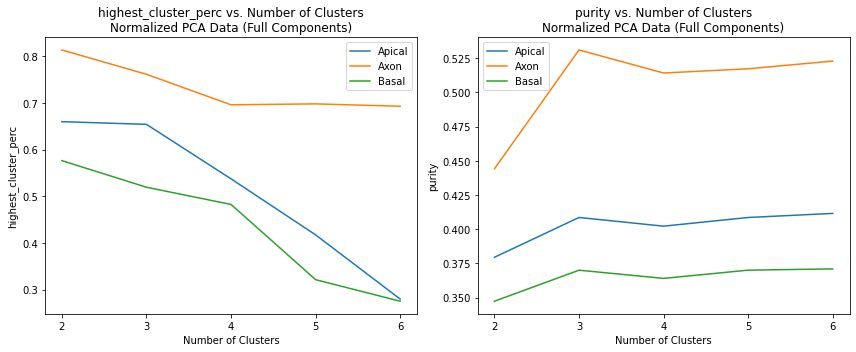

In [80]:
gmm = reload(gmm)
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Normalized PCA Data (Full Components)",
                 columns_picked = None,
                 possible_K = [2,3,4,5,6],
                 apply_normalization=True,
                 apply_pca=True,
                 
                )

# Part 4: GMM on PCA Dataset (4 Components)

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
Applying pca with 4 components
n_components = 4
whiten = True
---- Using sklearn method ----


<Figure size 432x288 with 0 Axes>

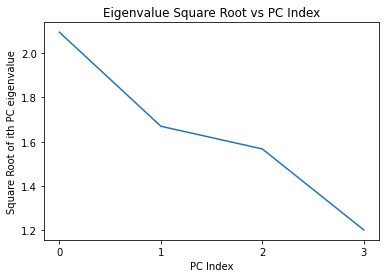

Explained Variance = [0.24358275 0.39851786 0.53504943 0.61538891]


<Figure size 432x288 with 0 Axes>

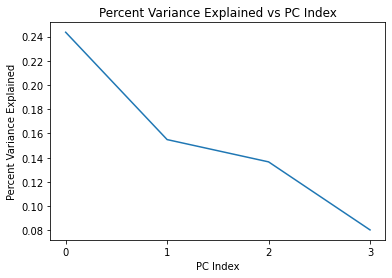

# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 1.1646842956542969


------Working on clusters K=3-----
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 3.852032423019409


------Working on clusters K=4-----
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 3.289205551147461


------Working on clusters K=5-----
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 4.519590377807617


------Working on clusters K=6-----
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 7.769459962844849


------Working on clusters K=7-----

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,292.643129,268.086463,17.534180,1.381710e+09,3.474738e+07,31462.983947,38164.769524,44.644305,84.259622,154.347623,148.106805,2.747052,8.191137e+07,8.887178e+06,5406.429370,17791.718689,58.077283,89.781606
1,471.788383,457.502091,5.229752,3.294646e+08,4.577154e+07,17721.712735,14447.649289,38.132628,82.033037,384.246323,342.525076,25.796575,1.726484e+09,4.743813e+07,37013.735959,44630.868605,36.201285,74.306554




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,887,7113
0,hard,Axon,2,6187,1813
1,hard,Basal,2,1980,6020




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,1,0.889125,1,0.434009
0,Axon,hard,2,0,0.773375,2,0.555972
1,Basal,hard,2,1,0.752500,2,0.357220




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,427.896714,409.082637,8.726041,7.401029e+08,5.356483e+07,30179.564474,19334.688816,38.182768,79.338236,356.700203,303.630452,37.597444,2.500575e+09,4.720083e+07,42832.578852,61371.650530,34.939415,70.310693
1,302.153242,267.871344,25.010647,2.228090e+09,4.407491e+07,54540.371551,48443.568494,42.324584,80.151339,150.113881,144.347070,-0.656667,-1.359274e+08,8.466088e+06,5586.506636,10790.307513,58.735329,90.925504
2,456.221819,447.837406,2.213951,-1.481728e+08,2.880465e+07,-1989.901594,12582.534176,41.353441,87.729131,337.884489,321.559858,5.483609,3.453741e+08,3.443661e+07,19124.462365,18802.439236,45.023481,83.866565




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,3423,565,4012
0,hard,Axon,3,832,1092,6076
1,hard,Basal,3,3971,1392,2637




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,2,0.501500,2,0.349250
0,Axon,hard,3,2,0.759500,2,0.422056
1,Basal,hard,3,0,0.496375,2,0.387366




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,514.533151,504.625337,2.190096,-7.453715e+07,3.536507e+07,3623.261454,10727.955561,37.536268,84.474051,402.044110,378.389893,7.637235,5.261694e+08,4.507279e+07,26923.991467,19086.914067,38.981131,80.310734
1,251.666294,239.522985,8.929889,3.346934e+08,1.758698e+07,-512.155209,27763.053251,49.466961,91.319121,117.502079,120.737646,-0.033640,-1.366186e+08,1.195776e+06,-2957.031757,18146.191257,62.285978,92.555775
2,422.112261,404.698724,7.622410,6.275068e+08,5.284924e+07,27528.591427,17765.783166,39.122485,80.344624,355.292449,300.148596,40.384943,2.682692e+09,4.727714e+07,43783.496364,65766.852008,34.876352,69.761122
3,360.764085,315.800800,31.705571,3.117003e+09,6.283621e+07,84554.826946,55312.389388,37.599476,73.626921,213.730557,191.890069,7.658936,4.618364e+08,2.092370e+07,18893.275726,17805.319277,51.931186,85.879384




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,4169,372,3006,453
0,hard,Axon,4,1645,5377,710,268
1,hard,Basal,4,2663,993,3474,870




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,0,0.521125,2,0.432072
0,Axon,hard,4,1,0.672125,2,0.590354
1,Basal,hard,4,2,0.434250,3,0.392137




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,509.069065,501.630779,0.727823,-2.532515e+08,3.004386e+07,-2624.791146,9320.680590,40.287665,88.120861,387.432938,369.654833,4.016864,2.725788e+08,4.067756e+07,22114.775361,15179.638815,42.536435,83.668277
1,351.542234,304.884103,33.201919,3.273731e+09,6.375166e+07,88272.789965,57668.180364,37.737192,73.247603,201.678529,180.750594,7.042537,4.160767e+08,1.914543e+07,17863.014841,16973.673275,52.945411,86.496606
2,491.419380,475.968283,6.081426,3.588212e+08,4.518552e+07,16865.807497,15660.129878,33.268661,77.510787,398.466338,363.819913,16.207435,1.104514e+09,4.949691e+07,34546.393451,29857.859919,33.911342,74.060821
3,407.022802,389.584277,7.709830,6.558568e+08,5.365781e+07,28813.833474,17966.639136,40.781056,81.514466,344.291451,285.704586,44.933311,2.977096e+09,4.617669e+07,45019.129642,72738.171747,35.612075,69.369837
4,255.508541,242.204940,9.794681,4.387831e+08,1.876318e+07,2471.385277,28899.053628,49.391586,91.116019,118.915681,122.136204,-0.421795,-1.608178e+08,1.252477e+06,-2873.856036,17288.736615,62.480836,92.882667




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,2899,399,1863,2463,376
0,hard,Axon,5,1672,266,462,599,5001
1,hard,Basal,5,1636,800,1789,2807,968




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,0,0.362375,3,0.420277
0,Axon,hard,5,4,0.625125,2,0.569174
1,Basal,hard,5,3,0.350875,4,0.392028




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,250.027566,239.075909,8.083583,2.423484e+08,1.602916e+07,-3134.702113,26684.945266,50.450532,92.604338,115.187611,119.045343,0.064469,-1.335747e+08,3.754068e+05,-3677.172328,18701.387855,63.036231,93.158643
1,499.446229,483.260970,6.767187,4.223730e+08,4.438436e+07,17831.833019,16776.284809,33.020460,77.560642,398.480241,367.928216,11.845879,8.155838e+08,4.840530e+07,32143.349351,23469.067789,34.954750,75.728477
2,513.208549,506.125987,0.425331,-2.784181e+08,2.968371e+07,-3137.372541,8840.465559,40.741545,88.801527,390.287483,372.655165,3.926662,2.669870e+08,4.072207e+07,22013.443577,15069.984650,42.818418,84.068496
3,410.168691,398.429850,3.369596,1.523327e+08,4.716093e+07,14541.459171,12062.008765,41.637555,83.805092,350.434334,294.751415,43.387246,2.872005e+09,4.619229e+07,43261.581011,71637.758587,35.558558,69.688429
4,421.406010,392.045425,17.084557,1.669255e+09,6.294302e+07,54835.838315,31219.473168,36.332262,75.170818,336.131611,284.068227,34.525716,2.296830e+09,4.458235e+07,41964.829987,55247.957336,36.659644,71.788626
5,303.032600,256.900138,34.187143,3.282293e+09,5.589730e+07,83647.323391,61135.524302,40.945041,76.278142,136.421651,128.921542,-1.585862,-1.938560e+08,6.911863e+06,6505.380138,7242.690214,60.334546,92.282336




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,311,1835,2638,2080,860,276
0,hard,Axon,6,5007,495,1484,484,253,277
1,hard,Basal,6,804,1594,1505,2248,1142,707




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,2,0.329750,3,0.424770
0,Axon,hard,6,0,0.625875,2,0.585857
1,Basal,hard,6,3,0.281000,4,0.397608




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,247.419618,236.555986,7.954785,2.093681e+08,1.635318e+07,-4.200989e+03,2.646903e+04,48.889225,90.836494,117.150428,120.517377,0.022119,-1.330552e+08,1.593131e+06,-2900.563781,18467.850836,61.512684,91.752161
1,356.136370,312.004949,31.064489,3.054391e+09,6.242258e+07,8.313722e+04,5.441624e+04,38.425625,74.469153,211.647814,188.369081,9.669349,5.925636e+08,2.074881e+07,19466.290302,20984.272237,52.092974,85.645304
2,403.109183,387.321566,6.405737,5.086909e+08,5.248367e+07,2.495141e+04,1.613134e+04,40.968667,81.865831,345.029044,285.330964,46.483765,3.079044e+09,4.665284e+07,45664.866827,75293.957469,35.053825,68.598300
3,505.144494,496.602657,1.304681,-2.236288e+08,3.296447e+07,-1.730394e+03,9.838312e+03,35.906573,82.892741,395.868315,375.062141,5.032797,3.517740e+08,4.470140e+07,25400.634892,15749.201416,38.110657,79.555580
4,488.462228,469.358161,8.796986,6.581330e+08,4.970742e+07,2.524041e+04,1.930028e+04,31.258051,74.420800,397.268327,360.440004,16.946312,1.158729e+09,5.067186e+07,36349.749842,29994.229390,32.558846,72.648057
5,600.832424,591.357236,1.239472,1.210997e+08,3.632496e+07,1.511995e+04,7.848786e+03,52.488119,102.805734,448.780079,420.983747,13.439145,9.101889e+08,4.282076e+07,27247.314133,27095.292949,49.669437,91.854841
6,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,354,562,2377,2886,1085,736,0
0,hard,Axon,7,5487,319,564,932,248,450,0
1,hard,Basal,7,931,1072,2686,1920,1237,154,0




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,3,0.360750,4,0.437275
0,Axon,hard,7,0,0.685875,2,0.610112
1,Basal,hard,7,2,0.335750,4,0.406762




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,607.060608,595.973997,2.460882,2.615271e+08,3.768645e+07,1.894432e+04,9.492315e+03,52.113180,102.304237,450.873487,423.867992,12.002916,8.174504e+08,4.283606e+07,26948.649659,24600.989793,49.918984,92.423499
1,473.149253,453.407801,9.623251,7.197044e+08,4.876983e+07,2.568582e+04,2.096961e+04,31.412576,74.201977,379.398922,345.229029,15.196068,1.034090e+09,4.791723e+07,34044.533266,27973.261490,33.892240,73.482567
2,400.064957,386.089905,5.065317,3.437861e+08,5.032818e+07,2.006644e+04,1.438644e+04,40.932081,82.156166,344.146638,285.469786,45.970475,3.043320e+09,4.650828e+07,45022.595332,74982.761775,34.853053,68.405927
3,295.625183,265.791254,21.856473,1.852336e+09,3.792377e+07,4.324381e+04,4.449570e+04,44.024275,82.902584,142.981659,141.112045,-2.514391,-2.685274e+08,6.214318e+06,2519.576949,9486.280044,60.233080,92.284400
4,509.479104,501.185277,1.074129,-2.412181e+08,3.277081e+07,-2.020979e+03,9.443728e+03,36.224088,83.404987,399.126800,378.370817,4.948414,3.470507e+08,4.487759e+07,25407.756835,15599.917503,38.270172,79.853688
5,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
6,432.346783,392.103540,25.630936,2.661694e+09,7.237133e+07,8.192664e+04,4.315501e+04,36.553766,73.698003,323.893713,273.651323,30.657690,2.041116e+09,4.140915e+07,40373.695789,47808.134642,40.287981,75.599962
7,200.893333,197.474031,2.973804,-3.957686e+08,6.390752e+06,-2.273021e+04,2.074741e+04,53.205612,95.850329,77.794399,84.179181,2.425709,-4.049743e+06,-4.852596e+06,-7320.514076,25167.661996,64.890426,92.950836




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,721,1213,2174,558,2772,0,521,41
0,hard,Axon,8,419,355,526,1219,909,0,115,4457
1,hard,Basal,8,154,1524,2489,1299,1794,0,538,202




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,4,0.346500,4,0.440585
0,Axon,hard,8,7,0.557125,3,0.637698
1,Basal,hard,8,2,0.311125,4,0.419377




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,291.022576,262.888578,20.616247,1.702567e+09,3.593921e+07,3.884834e+04,4.290192e+04,44.297655,83.440530,140.524663,139.296351,-2.497316,-2.701694e+08,5.827629e+06,1967.303243,9983.393888,60.256537,92.171976
1,613.915407,603.224032,2.363942,2.535758e+08,3.539278e+07,1.808899e+04,9.610584e+03,53.806411,104.651241,447.399978,424.732177,8.442473,5.762558e+08,4.036942e+07,23760.333355,19871.625824,52.470767,95.287382
2,472.963200,455.060378,8.360417,5.538918e+08,4.560656e+07,2.025491e+04,1.947313e+04,31.432304,74.783389,377.200852,346.548940,12.281144,8.380377e+08,4.691000e+07,31832.726204,24297.307017,34.412266,74.289130
3,197.820859,195.017434,2.565632,-4.397510e+08,5.544032e+06,-2.400666e+04,2.027191e+04,53.945903,96.696620,74.458384,81.038090,2.792774,1.715972e+07,-5.591599e+06,-7756.255004,25995.208880,65.484744,93.330670
4,420.327345,410.406211,2.013016,1.564199e+07,4.447133e+07,1.081043e+04,1.019478e+04,43.401699,86.478145,354.795035,301.455576,41.759089,2.761860e+09,4.522183e+07,41545.584213,69711.925012,37.141072,71.619753
5,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
6,396.034963,374.645925,10.750906,9.656664e+08,5.810190e+07,3.684037e+04,2.224880e+04,37.705975,77.045012,337.050772,277.070072,44.853227,2.975887e+09,4.706160e+07,46401.795050,71759.336031,33.747087,67.330324
7,516.388381,508.412932,0.757375,-2.678616e+08,3.255386e+07,-2.512523e+03,8.882292e+03,36.378277,83.832127,404.795894,384.211030,4.575404,3.245067e+08,4.536857e+07,25473.853567,14961.306048,38.257451,80.122991
8,434.499404,388.606689,30.427035,3.146006e+09,7.426556e+07,9.277460e+04,5.046465e+04,34.600142,71.064011,307.710962,266.203650,20.829651,1.387275e+09,3.771398e+07,35025.170109,32973.519577,42.632418,78.757260




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,537,641,1273,27,1692,0,944,2552,334
0,hard,Axon,9,1433,421,419,4155,386,0,242,843,101
1,hard,Basal,9,1292,135,1463,163,1613,0,1350,1595,389




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,7,0.319000,4,0.439129
0,Axon,hard,9,3,0.519375,3,0.628100
1,Basal,hard,9,4,0.201625,5,0.416061




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,408.230565,396.071443,3.488454,2.434091e+08,4.996389e+07,1.923024e+04,1.180814e+04,45.064082,86.939204,351.467224,288.510649,51.475726,3.404890e+09,4.638158e+07,46792.615258,83305.023840,36.669315,69.655023
1,290.810249,262.949717,20.409187,1.678184e+09,3.564111e+07,3.815434e+04,4.262318e+04,44.324775,83.522575,140.618497,139.481051,-2.515313,-2.715520e+08,5.828880e+06,1908.413457,10016.144505,60.233216,92.150523
2,468.503071,449.120146,9.523083,6.795286e+08,4.720689e+07,2.361163e+04,2.112690e+04,30.879985,73.740352,373.107413,341.825216,12.609427,8.597904e+08,4.679573e+07,32208.038703,24535.418994,34.224803,73.916854
3,427.670129,379.485889,32.378303,3.358891e+09,7.570122e+07,9.809333e+04,5.342831e+04,34.861878,70.776790,296.157402,255.716114,19.911609,1.321925e+09,3.580574e+07,33889.439518,31576.522699,43.932668,79.729904
4,453.577605,443.450407,2.302792,-3.158260e+07,4.058836e+07,6.829960e+03,1.086293e+04,39.120379,83.517671,371.482097,331.570453,26.078334,1.734689e+09,4.554828e+07,35183.762426,46439.995345,36.724935,74.174974
5,197.231647,194.505434,2.523336,-4.438629e+08,5.394790e+06,-2.413970e+04,2.023571e+04,54.125170,96.893736,73.610471,80.270471,2.832235,1.904180e+07,-5.792375e+06,-7883.094540,26110.984269,65.656116,93.456379
6,516.690621,508.892188,0.671899,-2.866217e+08,3.190370e+07,-3.357547e+03,8.848214e+03,36.190664,83.746623,403.916064,384.590743,3.357409,2.433217e+08,4.505010e+07,24730.217360,13279.908756,38.399498,80.398932
7,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
8,395.168695,372.278218,11.934151,1.089643e+09,5.940016e+07,3.998426e+04,2.393764e+04,36.917973,75.905119,334.828623,275.294388,43.922579,2.915260e+09,4.696842e+07,46258.616412,70119.059238,33.609179,67.266433
9,610.377657,600.065502,2.217120,2.282394e+08,3.415562e+07,1.689610e+04,9.621413e+03,54.342302,105.306859,441.541239,420.572525,7.329787,4.984139e+08,3.903430e+07,22377.605179,18608.905695,53.392198,96.102273




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,1218,539,966,295,1306,23,2334,0,688,631
0,hard,Axon,10,212,1449,361,95,349,4100,814,0,184,436
1,hard,Basal,10,915,1284,1313,341,1218,156,1471,0,1168,134




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,6,0.291750,5,0.441335
0,Axon,hard,10,5,0.512500,4,0.626472
1,Basal,hard,10,6,0.183875,5,0.418399




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,519.148260,511.165524,0.793169,-2.717499e+08,3.207390e+07,-2.920687e+03,8.981713e+03,36.075254,83.664473,405.606316,386.469912,2.990069,2.200269e+08,4.521486e+07,24709.397469,12651.235227,38.363748,80.490226
1,443.118568,429.776351,4.871144,2.441641e+08,4.380012e+07,1.405859e+04,1.457563e+04,38.088628,81.442752,360.856011,320.093017,26.420879,1.756224e+09,4.488239e+07,35578.525522,46501.249223,36.630467,73.654738
2,395.007386,371.525424,12.262633,1.149569e+09,6.113518e+07,4.244264e+04,2.418014e+04,37.354651,76.077815,337.176071,274.605019,46.799105,3.107252e+09,4.774910e+07,48064.317800,74042.874309,33.290174,66.645212
3,197.089214,194.322960,2.566541,-4.377977e+08,5.372075e+06,-2.397936e+04,2.030938e+04,54.275645,97.048706,73.007011,79.739510,2.826870,1.818806e+07,-5.963386e+06,-7988.444551,26127.026049,65.825464,93.598857
4,486.762414,479.624757,0.343813,-1.626401e+08,3.377718e+07,3.491567e+03,8.366983e+03,47.853975,94.912557,373.836564,342.105941,21.001247,1.382618e+09,3.900511e+07,28049.138029,40491.612642,45.540660,83.584170
5,465.479739,446.065704,9.435044,6.395880e+08,4.791379e+07,2.226180e+04,2.092443e+04,28.208170,70.726039,377.180316,345.176928,12.329822,8.473813e+08,4.889909e+07,33492.224046,23777.672979,31.680387,71.634274
6,426.490857,378.338899,32.375132,3.354193e+09,7.555513e+07,9.784096e+04,5.346305e+04,34.744795,70.639580,295.113424,254.927622,19.691222,1.306943e+09,3.569495e+07,33727.171905,31295.110748,43.911551,79.697515
7,291.575826,264.207305,20.008741,1.632572e+09,3.523265e+07,3.693846e+04,4.204181e+04,44.269920,83.578170,142.233316,141.064069,-2.465137,-2.677003e+08,6.093060e+06,2000.940470,10135.920356,60.023535,91.995331
8,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
9,404.274443,394.035047,2.016964,8.424442e+07,4.831692e+07,1.507569e+04,9.779908e+03,46.025809,88.190449,350.674607,286.833606,53.176770,3.514711e+09,4.623747e+07,47042.093441,86247.424525,36.794645,69.462971




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,2433,1107,702,23,560,697,296,557,0,1117,508
0,hard,Axon,11,783,292,184,4118,384,290,89,1492,0,194,174
1,hard,Basal,11,1504,1125,1081,159,239,1212,356,1309,0,922,93




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,0,0.304125,6,0.447336
0,Axon,hard,11,3,0.514750,4,0.627125
1,Basal,hard,11,0,0.188000,6,0.421260




----Working on Advanced Statistics for n_clusters = 12----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,477.406496,461.599530,6.627216,3.485125e+08,4.388967e+07,1.465651e+04,1.693675e+04,30.502489,74.318750,386.082631,355.591537,11.884776,8.159540e+08,4.854647e+07,32304.307119,23815.603074,32.962655,73.254118
1,444.124292,436.002099,0.996867,-1.873622e+08,3.747451e+07,1.943293e+03,9.405517e+03,40.723232,85.488184,361.013113,322.947842,25.808015,1.707822e+09,4.329229e+07,33259.689674,46969.490729,38.279260,75.267312
2,403.466023,348.802616,37.974420,3.909009e+09,7.891760e+07,1.103476e+05,6.214971e+04,32.298808,66.446680,261.940375,227.568392,13.408311,8.819445e+08,3.122939e+07,29641.022503,21847.257948,45.614549,81.029015
3,529.056029,521.394728,0.508581,-2.937873e+08,3.141320e+07,-3.420516e+03,8.502227e+03,36.523033,84.556508,411.538238,393.685679,1.571622,1.276726e+08,4.525924e+07,24037.336762,10540.116133,38.887569,81.447108
4,386.244201,370.955157,5.966979,4.264251e+08,5.320087e+07,2.251657e+04,1.555055e+04,38.667256,78.849285,340.889902,278.316372,49.078485,3.252771e+09,4.836436e+07,47846.351345,79046.978546,32.288236,65.334511
5,631.881860,620.065973,2.824545,3.294299e+08,3.833741e+07,2.138052e+04,9.636578e+03,52.242341,103.065802,467.774148,442.231088,9.409281,6.534647e+08,4.402056e+07,26660.543198,20197.181061,50.268142,93.851216
6,197.320770,195.009919,2.228516,-4.682874e+08,4.885594e+06,-2.469535e+04,1.984378e+04,54.959300,97.875773,72.668696,79.305784,3.253810,4.500701e+07,-6.298041e+06,-8122.858787,26900.381236,66.277552,93.957290
7,453.000362,420.910742,19.015823,1.884069e+09,6.464142e+07,6.046335e+04,3.361028e+04,34.245630,73.523637,355.347616,307.911326,27.482779,1.843153e+09,4.611797e+07,40436.112917,43819.372134,36.398780,73.396066
8,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
9,282.308134,267.592189,10.283835,4.907557e+08,2.243472e+07,4.887087e+03,2.874992e+04,44.701877,86.382996,151.652055,152.677355,-1.812321,-2.292394e+08,7.695642e+06,891.647735,13529.620581,57.616614,89.696540




Clustering Numbers By Neuroscience Category for K = 12


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11
2,hard,Apical,12,1194,1084,77,2116,1034,613,17,601,0,327,659,278
0,hard,Axon,12,357,354,30,704,298,363,3903,154,0,1551,85,201
1,hard,Basal,12,1382,992,139,1194,1620,126,141,772,0,713,208,713




Clustering Advanced Statistics By Neuroscience Category for K = 12


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,12,3,0.264500,6,0.451407
0,Axon,hard,12,6,0.487875,4,0.638552
1,Basal,hard,12,4,0.202500,6,0.432077




----Working on Advanced Statistics for n_clusters = 13----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,283.135253,268.666393,10.101084,4.728366e+08,2.210163e+07,4.414802e+03,2.850062e+04,44.984071,86.769443,151.883116,153.099300,-1.872842,-2.337656e+08,7.538428e+06,710.911793,13512.258132,57.841542,89.930481
1,448.577234,414.937824,20.348534,2.038498e+09,6.560246e+07,6.449304e+04,3.563146e+04,35.081202,74.031790,346.652256,299.706377,27.330670,1.828649e+09,4.443492e+07,39602.313103,43624.814209,37.797954,74.458645
2,635.479062,623.387816,3.070159,3.844501e+08,3.841788e+07,2.328684e+04,9.958472e+03,54.130198,105.139472,466.541552,440.859620,10.084228,6.949463e+08,4.285132e+07,26205.799841,21292.802408,51.938845,95.343761
3,462.769583,452.147325,2.382109,1.220594e+08,4.406337e+07,1.464834e+04,1.027401e+04,46.097374,90.642104,377.357835,327.959544,37.091464,2.458697e+09,4.487795e+07,39301.563830,62381.318976,40.217263,76.251053
4,396.227505,340.498231,38.866316,3.991877e+09,7.982922e+07,1.122082e+05,6.352212e+04,31.407915,65.084939,255.925859,221.634711,13.146534,8.638166e+08,3.095375e+07,29603.936090,21371.800689,45.257182,80.488933
5,589.555094,579.835662,1.479583,-7.275505e+07,3.468180e+07,5.341258e+03,8.707751e+03,38.786703,88.214158,454.236917,435.758719,-0.160205,3.082587e+07,4.835908e+07,25409.605107,6387.561088,40.349073,84.927294
6,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
7,478.731508,461.125873,7.929507,4.990933e+08,4.623723e+07,1.905146e+04,1.861632e+04,29.722140,73.087194,387.652094,355.878362,12.391861,8.528701e+08,4.929051e+07,33343.164735,24031.685570,32.379670,72.707985
8,385.562144,372.495238,4.394179,2.132492e+08,4.965430e+07,1.558226e+04,1.363270e+04,37.896241,78.660139,340.045031,281.356707,45.592319,3.020385e+09,4.787851e+07,45669.159070,74531.588423,32.106050,65.584827
9,472.265791,464.896377,0.634889,-3.251646e+08,3.219616e+07,-4.997692e+03,9.330508e+03,36.198082,82.372510,374.103561,350.498182,9.480392,6.356695e+08,4.320519e+07,26204.064957,23084.821558,37.754280,77.643546




Clustering Numbers By Neuroscience Category for K = 13


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12
2,hard,Apical,13,335,462,465,845,64,1725,0,920,844,1301,16,747,276
0,hard,Axon,13,1578,117,332,157,28,260,0,270,287,699,3923,143,206
1,hard,Basal,13,722,527,109,337,120,364,0,1208,1533,1527,144,699,710




Clustering Advanced Statistics By Neuroscience Category for K = 13


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,13,5,0.215625,7,0.47612
0,Axon,hard,13,10,0.490375,4,0.64344
1,Basal,hard,13,8,0.191625,7,0.44481




----Working on Advanced Statistics for n_clusters = 14----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,298.048277,258.082188,29.660824,2.756977e+09,4.828645e+07,6.846267e+04,5.521687e+04,43.064749,79.838832,133.057466,129.108475,-2.751172,-2.804929e+08,5.115023e+06,3674.162227,7205.363651,61.597602,93.434445
1,456.429566,434.771458,11.273916,9.070354e+08,5.069183e+07,3.071300e+04,2.350454e+04,32.232575,74.155337,363.167929,327.270329,17.601692,1.186234e+09,4.603966e+07,34274.029047,31590.446664,34.934934,73.521865
2,408.006601,398.702977,1.783603,-7.809952e+07,4.228801e+07,6.433444e+03,1.035692e+04,40.952972,83.862274,344.822173,295.603313,37.673692,2.489046e+09,4.446846e+07,39329.187776,64163.836093,36.164335,70.832465
3,195.970407,193.712623,2.225528,-4.680446e+08,4.669715e+06,-2.475086e+04,1.989043e+04,55.270454,98.196405,70.712778,77.543529,3.274981,4.495389e+07,-6.721335e+06,-8393.574618,27032.570742,66.618855,94.206827
4,523.300527,515.688678,0.542949,-2.960442e+08,3.120035e+07,-3.685460e+03,8.667049e+03,36.651267,84.547685,406.590756,388.744441,1.900587,1.469356e+08,4.467964e+07,23816.575899,11194.650997,39.082147,81.385155
5,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
6,687.543301,674.408394,3.340437,4.803846e+08,4.020642e+07,2.762902e+04,9.408991e+03,54.288156,106.590140,505.963595,481.322670,6.537462,4.785437e+08,4.643357e+07,26999.773218,14714.807614,51.845481,97.410318
7,443.252592,424.230722,8.562717,9.372415e+08,5.720831e+07,4.058322e+04,1.823076e+04,49.569518,91.301484,362.460031,297.460035,52.390384,3.468564e+09,4.478701e+07,47267.271730,83118.192869,41.492916,74.826752
8,507.143492,446.929706,40.748492,4.451064e+09,9.008712e+07,1.318251e+05,6.337371e+04,35.028294,70.584451,346.269959,302.413947,17.370032,1.184993e+09,4.045106e+07,37784.103746,23691.271534,45.224467,83.652417
9,502.794160,488.815282,5.026872,2.033694e+08,4.195561e+07,1.140826e+04,1.435937e+04,31.839660,76.904859,405.010101,376.113517,10.046012,6.994311e+08,4.953250e+07,31691.600910,21071.446246,33.699671,74.988228




Clustering Numbers By Neuroscience Category for K = 14


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13
2,hard,Apical,14,299,601,1012,13,2122,0,413,448,74,1249,388,303,394,684
0,hard,Axon,14,226,203,251,3799,742,0,193,62,18,288,320,1595,105,198
1,hard,Basal,14,759,742,1184,137,1242,0,71,123,52,1066,258,653,589,1124




Clustering Advanced Statistics By Neuroscience Category for K = 14


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,14,4,0.265250,7,0.449074
0,Axon,hard,14,3,0.474875,4,0.638640
1,Basal,hard,14,4,0.155250,7,0.428689




----Working on Advanced Statistics for n_clusters = 15----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,423.552587,413.939289,1.858881,-3.399702e+07,4.301631e+07,8.495632e+03,1.014833e+04,41.993211,85.316220,355.775857,305.998776,37.814619,2.502215e+09,4.514530e+07,39800.671735,64016.303526,36.773385,71.865691
1,382.694187,366.555569,6.545814,4.900662e+08,5.482010e+07,2.450109e+04,1.626092e+04,37.842725,77.585887,340.985978,276.523596,50.510796,3.349881e+09,4.926089e+07,49206.156539,80831.560176,31.299546,64.178704
2,281.092951,266.766870,10.015792,4.604694e+08,2.190021e+07,3.995127e+03,2.842432e+04,45.017280,86.779305,150.316297,151.566696,-1.770169,-2.278415e+08,7.364843e+06,623.268000,13744.360278,57.873440,89.879608
3,299.545587,258.518627,30.513453,2.860451e+09,4.908734e+07,7.131997e+04,5.642296e+04,43.506208,80.168261,131.143531,127.510430,-3.105965,-3.049455e+08,4.459202e+06,3299.152940,6569.983554,62.360494,94.173730
4,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
5,196.345329,193.993003,2.265336,-4.680280e+08,4.921515e+06,-2.476172e+04,1.991051e+04,54.737047,97.603380,72.205363,78.879003,3.170181,3.960707e+07,-6.237705e+06,-8103.936829,26769.742007,66.116426,93.793300
6,580.485429,570.890394,1.530040,-8.278395e+07,3.401260e+07,4.535147e+03,9.016270e+03,38.835482,88.088523,445.745707,428.034767,-0.391665,1.122958e+07,4.725251e+07,24619.079015,6372.340029,40.724730,84.976366
7,368.499192,318.914194,34.646496,3.443244e+09,7.122211e+07,9.487882e+04,5.856136e+04,31.867485,66.331546,234.691719,205.696817,10.789743,6.921030e+08,2.773717e+07,25491.477229,20094.958211,45.908735,80.478678
8,489.147327,483.726656,-0.664834,-2.713475e+08,2.974035e+07,-2.733063e+02,7.369570e+03,50.740036,98.713017,365.626965,338.761753,17.866546,1.164664e+09,3.539273e+07,24052.979631,36909.869509,49.011146,87.066183
9,711.350996,694.834856,5.510276,7.556976e+08,4.530049e+07,3.647652e+04,1.173270e+04,52.381781,104.372316,527.698203,500.464789,6.461587,4.892105e+08,5.007253e+07,29873.191865,12993.484187,49.963066,96.536809




Clustering Numbers By Neuroscience Category for K = 15


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14
2,hard,Apical,15,1136,681,333,283,0,15,1790,79,367,248,60,456,904,515,1133
0,hard,Axon,15,262,211,1628,198,0,3854,299,48,431,103,8,72,476,116,294
1,hard,Basal,15,1084,1153,722,692,0,141,405,192,198,47,21,148,1225,703,1269




Clustering Advanced Statistics By Neuroscience Category for K = 15


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,15,6,0.223750,7,0.473395
0,Axon,hard,15,5,0.481750,5,0.646063
1,Basal,hard,15,14,0.158625,7,0.442305




----Working on Advanced Statistics for n_clusters = 16----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,568.684364,559.337831,1.483653,-1.141481e+08,3.330903e+07,2.989468e+03,9.215196e+03,38.250505,87.222917,436.667879,419.628619,-0.641273,-8.940756e+06,4.647831e+07,24029.842061,6326.282800,40.513716,84.427101
1,295.897272,255.548586,30.064226,2.804526e+09,4.809227e+07,6.955854e+04,5.591552e+04,43.846943,80.600140,127.773148,124.679965,-3.179680,-3.124573e+08,3.849312e+06,2758.338647,6752.268031,62.688527,94.354075
2,382.074777,367.533528,5.452367,3.376793e+08,5.198658e+07,1.937355e+04,1.498890e+04,37.330920,77.530710,339.240454,278.224512,47.428089,3.143899e+09,4.858743e+07,47193.582477,76806.157650,31.398009,64.619910
3,321.928799,302.610770,13.090781,8.610616e+08,3.000395e+07,1.730330e+04,3.148228e+04,41.861725,83.238262,189.135602,185.642178,-1.450428,-1.796527e+08,1.388007e+07,5756.855626,11565.380678,54.432582,88.156922
4,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
5,713.128609,695.317440,6.239548,8.466396e+08,4.844375e+07,3.983055e+04,1.236897e+04,50.776702,102.205525,536.015121,504.858619,9.119091,6.731972e+08,5.277066e+07,32969.487017,16087.888039,47.726898,94.329140
6,653.093962,598.510000,32.855477,4.124680e+09,1.047413e+08,1.411023e+05,4.644676e+04,47.630646,86.689618,512.932418,425.375229,56.533168,3.843281e+09,6.359543e+07,67019.459147,76125.899664,39.925115,79.555664
7,245.408867,237.120373,5.914722,-4.804025e+07,1.398849e+07,-1.161831e+04,2.363686e+04,47.409740,89.715634,122.163471,126.029262,-0.521154,-1.662131e+08,3.095647e+06,-2633.487919,17965.384935,59.636352,90.152192
8,467.962945,460.250943,0.848131,-3.286481e+08,3.290878e+07,-5.437087e+03,9.621480e+03,34.027990,79.826924,374.991273,351.052855,9.058053,6.116805e+08,4.455507e+07,27005.487346,22203.390249,35.880112,75.912469
9,491.401358,473.518376,7.926907,5.327736e+08,4.748608e+07,2.099620e+04,1.823968e+04,30.309263,73.903187,399.109026,365.475347,13.687087,9.436759e+08,5.063884e+07,34736.828939,25480.782033,32.242609,72.863568




Clustering Numbers By Neuroscience Category for K = 16


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15
2,hard,Apical,16,1769,258,552,252,0,269,47,148,798,1145,9,526,1095,85,386,661
0,hard,Axon,16,310,189,212,361,0,92,7,1836,385,279,3371,120,254,43,441,100
1,hard,Basal,16,455,659,1217,587,0,49,11,260,1209,1257,112,664,806,181,153,380




Clustering Advanced Statistics By Neuroscience Category for K = 16


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,16,0,0.221125,7,0.475412
0,Axon,hard,16,10,0.421375,6,0.665551
1,Basal,hard,16,9,0.157125,8,0.455685




----Working on Advanced Statistics for n_clusters = 17----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,459.582515,450.657728,1.660684,-2.390077e+08,3.555262e+07,-2.524999e+03,1.060408e+04,32.784346,77.804235,373.922059,346.323556,12.118671,8.173494e+08,4.601642e+07,29500.617480,26232.052533,34.182781,73.785652
1,422.153806,403.765711,8.263369,8.646052e+08,5.633029e+07,3.771804e+04,1.818014e+04,48.586733,89.779468,348.357500,283.211851,53.236546,3.519172e+09,4.398688e+07,47088.054604,84850.930254,40.728424,73.362534
2,248.550670,239.741330,6.281453,-1.315602e+06,1.459132e+07,-1.020044e+04,2.408173e+04,47.380327,89.662265,124.097908,127.860708,-0.672912,-1.749685e+08,3.280192e+06,-2491.071853,17569.469528,59.677268,90.303666
3,676.361698,621.263080,32.975457,4.126032e+09,1.054175e+08,1.411525e+05,4.623283e+04,44.801632,84.292089,534.262034,448.739921,52.325891,3.578688e+09,6.674611e+07,67322.717949,69083.392103,37.755335,78.929061
4,424.087236,413.500928,2.586249,5.483731e+07,4.419055e+07,1.111631e+04,1.110917e+04,42.031972,85.144246,355.466042,305.026729,38.255074,2.531947e+09,4.516302e+07,40180.187520,64445.820853,36.882810,71.914394
5,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
6,383.794548,327.477562,39.693320,4.061585e+09,7.845223e+07,1.128785e+05,6.522202e+04,32.347174,65.848125,237.731480,206.893940,10.854309,7.017371e+08,2.751321e+07,26601.898868,18664.652095,47.463631,82.242529
7,701.659224,686.397583,4.742363,6.731690e+08,4.337523e+07,3.396748e+04,1.094123e+04,54.323140,106.475987,517.018117,490.281538,7.456958,5.463354e+08,4.789630e+07,28668.160957,15196.580352,51.645528,97.576581
8,192.154768,189.981712,2.229571,-4.723020e+08,4.321353e+06,-2.507268e+04,2.000286e+04,55.472590,98.346749,66.792880,73.961917,3.242106,4.052175e+07,-7.324257e+06,-8795.897434,27151.366866,66.934857,94.357878
9,328.339493,308.705411,13.166157,8.727676e+08,3.107450e+07,1.801012e+04,3.134882e+04,40.827274,82.172652,197.602312,193.041739,-1.246554,-1.602172e+08,1.559281e+07,6985.248283,11420.516519,53.184048,87.259670




Clustering Numbers By Neuroscience Category for K = 17


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16
2,hard,Apical,17,647,560,155,53,1049,0,79,238,9,237,795,260,368,1217,1309,555,469
0,hard,Axon,17,267,74,1809,8,213,0,47,121,3477,292,207,190,360,434,193,198,110
1,hard,Basal,17,992,186,285,13,954,0,167,53,117,575,999,670,215,714,280,1122,658




Clustering Advanced Statistics By Neuroscience Category for K = 17


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,17,14,0.163625,8,0.475836
0,Axon,hard,17,8,0.434625,6,0.664816
1,Basal,hard,17,15,0.140250,8,0.455302




----Working on Advanced Statistics for n_clusters = 18----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,554.886838,546.337197,1.361491,1.444300e+07,3.155388e+07,8.412163e+03,9.430809e+03,50.862825,100.407162,405.252392,384.751337,8.427710,5.583136e+08,3.728301e+07,21656.436769,21482.295321,50.799796,91.876204
1,475.266734,467.421583,0.712783,-3.122323e+08,3.451567e+07,-3.843547e+03,9.047785e+03,34.366367,80.174145,384.780517,357.593517,11.807065,7.985893e+08,4.627397e+07,29239.682589,25788.756399,35.162902,75.217985
2,420.923413,369.754010,34.909017,3.562751e+09,7.673848e+07,1.015052e+05,5.739841e+04,30.542337,65.667844,286.849186,251.794967,13.056651,8.708171e+08,3.538422e+07,31428.826893,21130.415009,42.577245,79.067394
3,412.394820,403.988842,0.929683,-1.236350e+08,4.273166e+07,6.582701e+03,8.857072e+03,43.277726,86.447506,350.424784,297.507956,41.945196,2.771291e+09,4.489712e+07,41158.431955,70441.162672,36.850781,71.100203
4,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
5,542.813367,535.560269,0.257408,-3.108616e+08,2.970954e+07,-4.108720e+03,8.190163e+03,37.746590,86.538379,415.975862,401.623794,-1.737709,-9.232904e+07,4.410842e+07,21769.975626,5868.898348,40.662297,83.839551
6,237.289717,229.838048,5.443297,-1.018543e+08,1.250169e+07,-1.340342e+04,2.322826e+04,48.772994,91.168467,113.014456,117.569390,-0.079003,-1.439216e+08,1.296322e+06,-3745.981348,19192.312958,60.949836,90.981661
7,389.317272,373.270331,6.171818,5.409048e+08,5.734693e+07,2.849428e+04,1.515178e+04,41.681546,81.491506,349.251342,277.398878,58.547176,3.881754e+09,5.006285e+07,52966.907734,92327.825765,32.464279,64.494268
8,294.758630,251.715604,32.160753,3.045619e+09,5.080662e+07,7.622051e+04,5.883040e+04,43.621717,79.767880,123.627220,119.961590,-3.127504,-3.087541e+08,3.389744e+06,3013.446258,6362.352948,63.101009,94.629707
9,644.772580,573.622796,45.707240,5.533217e+09,1.210599e+08,1.787386e+05,6.440561e+04,41.579414,76.659420,492.219184,403.831725,52.559987,3.590332e+09,6.310357e+07,68362.217610,67077.268549,39.082788,78.760971




Clustering Numbers By Neuroscience Category for K = 18


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
2,hard,Apical,18,749,765,105,985,0,1498,87,...,238,18,110,288,892,558,314,9,332,388
0,hard,Axon,18,461,275,42,253,0,445,1710,...,172,5,27,508,192,248,47,3280,138,80
1,hard,Basal,18,156,884,215,1030,0,660,186,...,609,7,21,652,719,861,63,101,696,431




Clustering Advanced Statistics By Neuroscience Category for K = 18


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,18,5,0.18725,8,0.457224
0,Axon,hard,18,15,0.41000,5,0.657513
1,Basal,hard,18,3,0.12875,9,0.446181




----Working on Advanced Statistics for n_clusters = 19----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,516.246743,494.952295,10.315179,8.692994e+08,5.156668e+07,3.172869e+04,2.104499e+04,32.047694,75.704404,412.483397,377.333627,14.043249,9.733456e+08,5.108365e+07,35698.741295,24943.007727,33.927873,75.076987
1,388.147005,373.185042,5.426897,4.448186e+08,5.557120e+07,2.539446e+04,1.426798e+04,41.806565,81.908768,347.311828,277.209399,57.222805,3.791875e+09,4.943013e+07,51804.873429,90752.634756,32.795179,64.909961
2,293.351792,275.913272,12.206974,7.274216e+08,2.583483e+07,1.201463e+04,3.111823e+04,44.074915,85.403814,159.353485,159.117017,-1.876072,-2.269334e+08,8.875691e+06,2106.744976,12540.586284,57.283051,89.747262
3,295.480210,252.688530,31.932166,3.015846e+09,5.070198e+07,7.540231e+04,5.847577e+04,43.190309,79.366126,125.662830,121.915041,-3.220347,-3.134466e+08,3.892500e+06,3250.754754,6181.713281,62.608295,94.239903
4,448.822614,434.350515,5.940541,1.832483e+08,4.125198e+07,7.987884e+03,1.666169e+04,27.644588,70.881092,366.584393,338.929961,9.705302,6.653947e+08,4.747666e+07,30614.936132,21420.883875,31.304420,71.117495
5,186.165879,184.391845,2.058837,-4.868862e+08,3.438314e+06,-2.561964e+04,1.994721e+04,56.811560,99.725790,59.225658,66.734982,3.822050,7.306530e+07,-8.899940e+06,-9632.227714,28424.764667,68.215290,95.208374
6,482.672239,475.276356,0.574383,-3.536017e+08,3.182503e+07,-6.219216e+03,9.165084e+03,34.249778,80.687633,383.334104,362.078087,6.034094,4.141468e+08,4.458294e+07,25638.270682,17706.755527,36.531586,77.326351
7,551.205778,543.432830,0.818776,-3.600727e+07,3.075262e+07,7.179761e+03,8.739481e+03,52.123293,101.787837,401.614479,380.602285,9.708567,6.391724e+08,3.644018e+07,21499.193235,23697.890144,51.619599,92.329053
8,807.217250,785.359810,7.462117,1.229161e+09,6.165548e+07,5.851456e+04,1.092545e+04,52.189140,104.469499,629.521389,580.679980,20.778425,1.493182e+09,6.614336e+07,46740.939577,28802.911082,43.509227,92.439883
9,583.243808,513.105871,46.795954,5.460096e+09,1.093265e+08,1.689306e+05,6.884895e+04,42.274141,77.214650,410.094348,343.576013,35.865524,2.439963e+09,4.821463e+07,51943.458105,46327.819173,46.737653,85.270832




Clustering Numbers By Neuroscience Category for K = 19


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18
2,hard,Apical,19,977,670,316,232,260,4,982,...,23,0,449,325,67,753,1344,734,77,93
0,hard,Axon,19,190,132,935,181,153,2848,456,...,5,0,79,46,1757,173,222,198,46,86
1,hard,Basal,19,718,758,689,636,688,79,1176,...,11,0,450,79,159,729,294,689,188,500




Clustering Advanced Statistics By Neuroscience Category for K = 19


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,19,15,0.168,8,0.478144
0,Axon,hard,19,5,0.356,5,0.652605
1,Basal,hard,19,6,0.147,9,0.453826




----Working on Advanced Statistics for n_clusters = 20----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,407.185615,393.271806,5.404831,2.718626e+08,4.591899e+07,1.463383e+04,1.556536e+04,36.586008,78.413801,341.069576,294.965660,32.339247,2.142828e+09,4.509392e+07,38460.231374,55340.676664,34.472982,69.880029
1,516.518935,494.597045,10.824471,9.736078e+08,5.249618e+07,3.547677e+04,2.168842e+04,35.042995,78.701615,408.348628,371.156938,17.015087,1.164575e+09,4.948989e+07,35995.541528,29418.873306,36.191551,76.704453
2,294.729257,252.464361,31.559165,2.976700e+09,5.002373e+07,7.431842e+04,5.799915e+04,43.731128,80.043875,124.496145,120.954190,-3.069283,-3.051800e+08,3.475464e+06,2941.125053,6593.856572,63.015266,94.558641
3,514.318508,506.997455,0.370733,-3.572113e+08,3.073906e+07,-6.176662e+03,8.596384e+03,34.444257,82.025887,403.081525,386.058377,0.727889,7.060602e+07,4.534540e+07,23766.151942,9526.096134,37.405548,79.763195
4,408.258534,373.851678,21.092778,2.129340e+09,6.822834e+07,6.754038e+04,3.691964e+04,36.444888,73.808266,320.104040,265.616454,36.606868,2.430784e+09,4.294715e+07,42812.222634,57660.357713,37.694966,71.934351
5,191.621456,189.483842,2.220213,-4.752885e+08,4.178001e+06,-2.523161e+04,2.001817e+04,55.482380,98.363158,66.060506,73.458769,3.066830,2.848486e+07,-7.465503e+06,-8963.931543,26934.768178,67.008535,94.424564
6,463.819471,446.569334,6.970082,8.386892e+08,5.639971e+07,3.975017e+04,1.553557e+04,53.557477,96.374309,377.431736,310.105058,55.445070,3.671199e+09,4.498145e+07,48180.584895,87675.316934,43.560485,76.993033
7,6891.203077,4058.537154,2101.577886,2.610105e+11,3.225052e+09,7.722954e+06,2.751256e+06,359.031590,-14.591177,2012.624989,788.133890,478.285633,3.401315e+10,3.888256e+07,731824.663406,49377.572484,675.257498,754.134039
8,481.979507,474.245440,0.643367,-2.472721e+08,3.458379e+07,-7.431454e+02,8.816028e+03,39.110261,85.385020,383.372051,354.263721,15.187836,1.015032e+09,4.404443e+07,29106.629065,31057.988351,38.715657,78.147128
9,455.480084,443.801853,3.982311,-1.375299e+07,3.685437e+07,2.429666e+03,1.415138e+04,31.161629,75.600794,364.536627,340.255906,8.165879,5.546543e+08,4.469531e+07,27580.233367,20189.283435,34.535011,74.367475




Clustering Numbers By Neuroscience Category for K = 20


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18,cl_19
2,hard,Apical,20,486,953,242,1245,358,8,335,...,78,86,247,116,72,272,662,997,19,796
0,hard,Axon,20,166,177,174,408,80,3313,47,...,42,17,338,1721,86,582,149,119,5,163
1,hard,Basal,20,720,599,615,868,451,109,78,...,177,17,92,206,492,644,903,126,8,695




Clustering Advanced Statistics By Neuroscience Category for K = 20


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,20,3,0.155625,9,0.481917
0,Axon,hard,20,5,0.414125,6,0.664530
1,Basal,hard,20,16,0.112875,10,0.452731


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


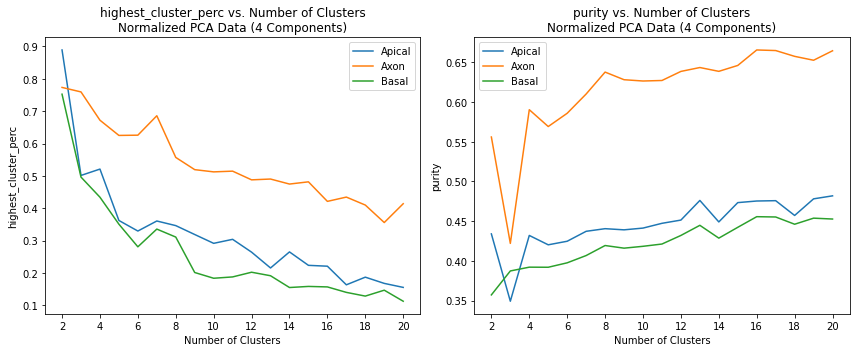

In [31]:
gmm = reload(gmm)
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Normalized PCA Data (4 Components)",
                 columns_picked = None,
                 possible_K = np.arange(2,21),
                 apply_normalization=True,
                 apply_pca=True,
                 n_components_pca=4
                 
                )

# Part 5: Apply Variational Inference To Gaussian Mixture Model

In [39]:
# from os import sys
# sys.path.append("/notebooks/Neurosignal_Final/PRML/")
# from prml.rv import VariationalGaussianMixture

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
Applying pca with 4 components
n_components = 4
whiten = True
---- Using sklearn method ----


<Figure size 432x288 with 0 Axes>

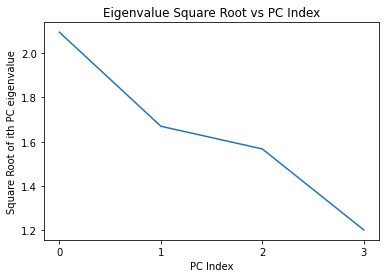

Explained Variance = [0.24358275 0.39851786 0.53504943 0.61538891]


<Figure size 432x288 with 0 Axes>

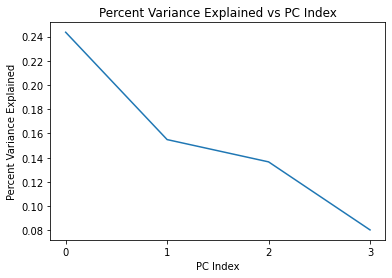

# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 12.775046348571777


------Working on clusters K=3-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 27.450862169265747


------Working on clusters K=4-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 35.38390636444092


------Working on clusters K=5-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 41.98052954673767


------Working on clusters K=6-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 49.78534817695618


------Working on clusters K=7-----
Using va

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,386.018022,364.861634,13.443717,1.054455e+09,3.635734e+07,27310.989867,30158.808761,43.775165,86.217215,246.705850,235.095339,3.417868,1.695897e+08,2.083531e+07,12290.277659,16331.504175,53.290474,88.740575
1,441.812491,427.281277,5.535826,3.386221e+08,4.704787e+07,17749.529131,15129.281691,37.316994,80.052751,366.506458,320.819413,30.498956,2.031953e+09,4.713390e+07,38961.779763,51797.610503,34.869888,71.595148




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,2933,5067
0,hard,Axon,2,6603,1397
1,hard,Basal,2,2495,5505




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,1,0.633375,2,0.357514
0,Axon,hard,2,0,0.825375,1,0.473374
1,Basal,hard,2,1,0.688125,2,0.381172




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,452.036906,444.394480,1.831396,-1.982616e+08,2.696090e+07,-3926.689969,12322.483237,42.395085,89.007803,330.444577,316.232397,4.285739,2.600705e+08,3.258377e+07,17301.007896,17590.965594,46.425329,85.092299
1,311.055685,276.444361,25.005169,2.244639e+09,4.576373e+07,55862.121614,48047.221254,41.545264,79.343853,162.105783,153.869810,0.816434,-3.085921e+07,1.079279e+07,7724.608887,12352.468092,57.273038,89.780659
2,434.175128,416.450261,7.858968,6.370233e+08,5.215771e+07,27194.968517,18099.873033,37.913866,79.517728,362.157027,310.549772,36.022716,2.398207e+09,4.763381e+07,42221.087210,59162.169840,34.714098,70.522766




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,3616,626,3758
0,hard,Axon,3,5959,1123,918
1,hard,Basal,3,2254,1498,4248




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,2,0.469750,2,0.351075
0,Axon,hard,3,0,0.744875,2,0.435594
1,Basal,hard,3,2,0.531000,2,0.392841




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,434.060384,428.239544,1.028520,-3.142464e+08,2.194159e+07,-8871.769841,12080.979527,45.364917,92.414375,304.159491,295.685819,1.372495,4.800171e+07,2.682078e+07,12086.087056,14957.121838,50.519415,88.405908
1,295.892730,262.707025,24.355907,2.144714e+09,4.198633e+07,51679.856341,47817.585670,43.297523,81.351331,142.106100,138.166906,-1.464339,-1.957091e+08,6.713670e+06,3931.149147,10224.478484,59.926125,91.858059
2,412.005294,390.912255,10.456223,9.665736e+08,5.749970e+07,37421.252842,21657.588866,39.461972,79.494543,345.577494,286.628829,43.901677,2.913755e+09,4.671583e+07,45636.019893,70327.054422,35.279796,69.314926
3,476.429052,463.129988,4.775232,1.986515e+08,4.148158e+07,11578.936003,14368.669847,35.412966,79.974809,381.760026,349.500041,15.948565,1.074477e+09,4.616043e+07,31923.609571,30687.654819,36.153857,75.565564




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,2259,563,2341,2837
0,hard,Axon,4,5085,1364,544,1007
1,hard,Basal,4,1257,1372,2723,2648




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,3,0.354625,3,0.363298
0,Axon,hard,4,0,0.635625,2,0.472404
1,Basal,hard,4,2,0.340375,3,0.394569




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,407.202719,389.860915,7.676873,6.216093e+08,5.293730e+07,27130.141434,18035.643684,39.151826,79.908453,344.863367,288.454150,42.281990,2.803681e+09,4.654289e+07,44152.350988,68833.368563,34.753849,68.935219
1,411.706363,406.392195,1.042518,-3.437557e+08,1.986595e+07,-10949.239733,12730.888346,46.319242,93.058132,281.470906,275.132411,0.947798,7.098926e+06,2.340312e+07,9706.881721,15297.019848,52.206374,89.174721
2,481.990274,470.128686,3.663276,4.752128e+07,3.939448e+07,6808.780319,12868.181446,34.094991,79.143748,387.603494,358.049815,12.898164,8.756425e+08,4.690887e+07,30849.721851,26354.845432,35.262472,75.348592
3,291.488720,259.632344,23.405516,2.022860e+09,4.028305e+07,47934.053135,46638.755317,43.206009,81.446323,139.527567,136.526735,-1.937159,-2.291333e+08,6.390555e+06,3291.172824,9918.246365,59.810513,91.682300
4,534.539560,501.466512,19.289585,2.094400e+09,6.514623e+07,69551.406336,32849.678970,41.940903,84.021495,401.096191,356.344501,24.079136,1.627374e+09,4.571802e+07,38503.633471,37859.399364,43.043327,82.299395




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,2430,1878,2356,559,777
0,hard,Axon,5,614,4880,794,1482,230
1,hard,Basal,5,2974,1018,2224,1386,398




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,0,0.30375,3,0.373567
0,Axon,hard,5,1,0.61000,3,0.490131
1,Basal,hard,5,0,0.37175,3,0.399582




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,239.954759,231.576866,6.195037,1.267075e+07,1.330013e+07,-9811.876059,24252.043697,50.687861,93.097996,110.385863,114.443022,0.875404,-8.412868e+07,-8.310428e+03,-4041.921853,20593.407964,62.739665,92.504960
1,305.997234,264.277441,30.709032,2.880848e+09,5.166713e+07,72620.687842,56243.222289,40.907896,77.216306,145.378884,138.531559,-1.626685,-1.952817e+08,8.194047e+06,6445.756407,7839.505719,59.195365,91.459783
2,395.364854,383.194710,3.828252,1.823558e+08,4.753388e+07,14879.449926,12930.694704,41.043449,82.641024,339.578244,283.306573,44.324311,2.930327e+09,4.551189e+07,43370.257389,73192.199165,35.214358,68.776239
3,514.491986,506.158342,1.095137,-2.190305e+08,3.273382e+07,-1081.370102,9411.481861,37.396843,84.799672,400.750488,379.994429,5.177184,3.612094e+08,4.438998e+07,25161.623700,15958.046993,39.251521,80.849171
4,587.273803,555.627131,17.993592,2.028730e+09,6.220432e+07,68862.112794,30545.537598,45.961175,90.397247,430.810751,391.480631,18.441691,1.259624e+09,4.521440e+07,35281.983994,29478.478266,46.968648,88.157803
5,461.303527,438.862456,11.487219,1.003888e+09,5.461640e+07,35816.435116,23136.874977,33.984773,75.550681,373.879652,329.903356,25.367800,1.705202e+09,4.834376e+07,39087.567397,42261.159621,34.306874,72.238161




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,278,358,1939,3144,586,1695
0,hard,Axon,6,5397,344,535,1129,204,391
1,hard,Basal,6,728,905,2319,1883,217,1948




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,3,0.393000,3,0.441895
0,Axon,hard,6,0,0.674625,2,0.621087
1,Basal,hard,6,2,0.289875,4,0.409731




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,418.305186,401.394834,7.297534,5.733884e+08,5.198745e+07,25595.742020,17440.855212,38.573264,79.802141,352.760108,298.570236,39.550224,2.626532e+09,4.711191e+07,43256.836206,64727.565532,34.579461,69.477552
1,284.902008,270.334449,10.147298,4.797483e+08,2.230231e+07,4682.943746,28518.884357,44.860725,86.658973,153.591869,154.699287,-1.923241,-2.360369e+08,7.802765e+06,872.261924,13352.070433,57.699267,89.870730
2,570.609384,556.612765,4.571646,3.853929e+08,4.291117e+07,21077.695982,12530.086071,43.318574,90.972850,441.111623,409.370163,14.061384,9.654340e+08,4.769181e+07,31746.483620,26511.629397,42.076450,84.097667
3,426.126992,380.776421,29.958240,3.092445e+09,7.465367e+07,91604.224658,49767.530878,34.354893,70.528259,305.835749,261.818501,23.522302,1.565324e+09,3.842123e+07,36532.758071,36966.897063,41.666019,77.333581
4,504.514254,495.971707,1.249678,-2.315774e+08,3.337713e+07,-1821.618954,9694.536069,35.417147,82.298691,397.557436,375.927515,5.621004,3.924387e+08,4.537836e+07,26088.009356,16490.276727,37.443987,78.887209
5,197.003830,194.654657,2.261163,-4.649779e+08,4.921147e+06,-24614.364345,19894.253092,54.948057,97.846613,72.388711,79.010330,3.272385,4.615191e+07,-6.320958e+06,-8120.902492,26926.941975,66.278901,93.945094
6,302.148275,261.154727,30.323605,2.836684e+09,4.998561e+07,71008.630918,55946.606614,42.239008,78.786939,138.234485,133.049719,-2.312998,-2.468952e+08,6.335054e+06,4829.013215,7366.508047,60.725164,92.749191




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,2963,339,1389,255,2741,16,297
0,hard,Axon,7,762,1570,530,78,913,3927,220
1,hard,Basal,7,3729,714,421,327,1911,143,755




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,0,0.370375,3,0.445513
0,Axon,hard,7,5,0.490875,3,0.638614
1,Basal,hard,7,0,0.466125,4,0.425873




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,407.566679,402.683051,0.886835,-3.573328e+08,1.854025e+07,-11626.764496,12745.275478,47.887806,94.800835,273.553380,268.560616,0.614390,-2.160200e+07,2.138621e+07,8191.050152,15307.373867,53.945265,90.591403
1,500.356549,487.152381,4.666835,1.585360e+08,3.965262e+07,9507.105469,14184.040317,33.384909,78.835635,396.680388,370.821964,8.123918,5.647612e+08,4.705284e+07,29145.138397,18906.690415,35.783533,76.949407
2,449.735514,431.200681,9.444217,7.764300e+08,4.479030e+07,27291.004147,21592.059631,41.758785,85.038508,338.593530,305.721488,19.504055,1.283769e+09,3.772453e+07,29043.520686,36569.751337,43.565821,80.626795
3,957.284419,912.593774,22.636222,3.358496e+09,9.541033e+07,128841.131978,27617.226522,56.305162,107.182951,740.553657,668.250571,33.118007,2.375451e+09,7.924728e+07,63972.563150,38047.386968,44.456901,96.582229
4,442.574227,435.049384,0.447221,-2.672157e+08,3.741197e+07,-338.890947,8568.241575,39.128573,83.805696,364.933604,326.264343,25.888125,1.717114e+09,4.482256e+07,34184.987463,46952.691921,36.532138,73.695373
5,284.375780,253.910991,22.535857,1.914008e+09,3.785429e+07,44334.246836,45736.553072,44.261211,82.774193,131.017601,129.927513,-2.699297,-2.864623e+08,4.551769e+06,1545.053431,9504.731658,61.029148,92.609322
6,416.293660,376.412397,25.568040,2.604621e+09,7.110863e+07,79081.333829,43478.879694,34.975914,71.739745,311.785884,263.450429,29.093730,1.933642e+09,4.054024e+07,39186.289079,45936.062075,39.581585,74.628971
7,399.077525,382.077454,7.169307,5.890307e+08,5.511980e+07,27572.472994,16982.195077,39.145108,79.366273,348.026964,285.179168,48.633615,3.227044e+09,4.871475e+07,48154.445214,77843.324621,32.915516,66.339209




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,1637,2095,777,76,1012,483,417,1503
0,hard,Axon,8,4599,610,562,12,326,1420,109,362
1,hard,Basal,8,863,1566,536,15,1204,1229,569,2018




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,1,0.261875,5,0.375142
0,Axon,hard,8,0,0.574875,3,0.495824
1,Basal,hard,8,7,0.252250,5,0.403933




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,291.534397,260.694211,22.730754,1.949924e+09,3.853242e+07,45711.503300,45841.709479,44.395909,83.016775,136.638398,135.120346,-2.654525,-2.807573e+08,5.134909e+06,1977.008647,9310.451032,61.017587,92.830179
1,466.107329,449.486623,7.596229,4.646332e+08,4.320472e+07,17288.319027,18728.367504,33.092946,76.747111,367.533873,338.738415,11.783794,7.968746e+08,4.461759e+07,29918.450282,24324.792664,36.184176,75.673926
2,428.753509,420.938844,0.575916,-1.924758e+08,3.996925e+07,3490.042039,8528.548881,42.254945,86.300040,357.407431,311.180815,34.704101,2.294640e+09,4.438659e+07,37648.067732,59945.103653,37.444808,73.007423
3,435.119788,396.753557,24.184381,2.474570e+09,7.002559e+07,76253.956899,41199.454964,35.486930,73.111395,328.524015,280.378159,28.473059,1.898536e+09,4.211445e+07,39556.260385,44863.999107,39.365063,75.168535
4,395.579852,378.127312,7.602976,6.322412e+08,5.517341e+07,28480.485753,17709.786167,39.259559,79.341926,343.268633,281.027102,48.217011,3.197221e+09,4.793587e+07,47583.240922,77320.224358,33.377457,66.664185
5,874.309112,814.672747,34.410443,4.634345e+09,1.140410e+08,163692.890463,44471.177047,51.238814,95.672776,678.884943,591.854945,46.128245,3.228868e+09,7.804218e+07,71919.214814,54973.738411,41.204433,89.249513
6,578.638695,569.926439,1.366953,5.256822e+07,3.127343e+07,10064.066477,9163.561969,52.342508,102.729407,418.850921,400.189790,6.176823,4.130114e+08,3.733639e+07,20664.365584,17909.186571,52.324541,94.258778
7,522.187171,514.470659,0.596851,-2.988562e+08,3.147697e+07,-3851.336288,8726.328022,35.880689,83.654348,407.375901,389.342576,1.796698,1.416920e+08,4.522886e+07,24160.014536,10935.264237,38.385304,80.752153
8,197.352377,194.661008,2.496728,-4.472309e+08,5.345505e+06,-24242.598980,20199.785495,54.111826,96.892606,73.718144,80.432295,2.777003,1.541993e+07,-5.784879e+06,-7908.338768,26035.236146,65.648076,93.460295




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,520,1682,1123,529,1348,50,748,1977,23
0,hard,Axon,9,1365,656,298,135,315,8,512,638,4073
1,hard,Basal,9,1241,1805,1101,621,1702,13,152,1207,158




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,7,0.247125,5,0.435178
0,Axon,hard,9,8,0.509125,4,0.621444
1,Basal,hard,9,1,0.225625,5,0.415809




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,424.341662,417.401276,-0.235030,-2.517684e+08,4.068700e+07,2992.306441,7173.857410,43.579498,87.518441,358.835704,308.188199,39.650990,2.621364e+09,4.513765e+07,40020.016165,67236.856982,37.173299,72.067680
1,399.078034,385.114424,5.035391,3.397367e+08,5.052565e+07,20018.775379,14320.748291,40.749552,81.906086,344.426685,285.268304,46.387673,3.071456e+09,4.677463e+07,45371.101488,75554.978609,34.562616,68.072432
2,526.499899,517.455596,1.346699,-1.831545e+08,3.474335e+07,604.402844,9335.664607,35.654801,83.001670,415.757382,393.172475,5.462870,3.905891e+08,4.733983e+07,27277.478733,15568.360333,37.170851,79.402144
3,480.882187,463.362195,7.903559,5.295737e+08,4.607224e+07,20424.088201,18562.387045,32.132456,75.725966,385.457242,353.045180,13.864292,9.458152e+08,4.791342e+07,33016.874256,26415.413921,34.294541,74.277739
4,630.265747,617.579744,3.413795,4.609684e+08,4.058081e+07,26576.806539,10218.157225,55.604914,106.191484,465.044534,434.591739,15.213390,1.033165e+09,4.314198e+07,28643.715925,28635.300315,52.128587,94.736062
5,296.824863,235.356083,46.587917,4.729962e+09,6.832044e+07,122836.055652,78936.310219,44.293384,76.861833,95.621208,90.238051,-4.363406,-3.925850e+08,-1.559742e+06,2867.580596,1596.629282,68.381817,99.168469
6,279.158174,257.191633,15.994317,1.151184e+09,2.930937e+07,23030.952911,36770.714736,44.812161,84.957199,137.871777,138.088595,-2.049989,-2.467776e+08,5.584756e+06,852.187926,12087.861450,59.581576,91.222088
7,396.783908,371.362817,13.914186,1.314444e+09,6.165456e+07,46052.605528,26705.412288,36.594322,75.129379,332.074100,272.911537,42.963218,2.852450e+09,4.646276e+07,46021.257823,68270.228712,34.116788,67.836019
8,427.151478,382.073528,29.969865,3.069175e+09,7.250683e+07,89842.142652,50119.639356,34.375763,70.901988,300.481367,261.047511,19.318162,1.283173e+09,3.660527e+07,33563.713454,31221.499892,42.919213,78.943854
9,350.242011,346.164990,1.108690,-4.191619e+08,1.498689e+07,-16201.841662,14430.260107,48.438258,94.168450,221.947948,220.047521,0.865854,-3.094524e+07,1.496514e+07,4267.573106,17606.976514,56.021595,90.446110




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,878,1172,2064,1333,452,61,463,476,343,758
0,hard,Axon,10,216,272,579,387,358,38,1791,121,117,4121
1,hard,Basal,10,907,1237,1194,1471,102,130,1153,746,444,616




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,2,0.258000,6,0.408913
0,Axon,hard,10,9,0.515125,3,0.548770
1,Basal,hard,10,3,0.183875,6,0.401055




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,614.266966,601.704336,3.511585,4.126903e+08,3.961868e+07,23840.587451,10752.146870,53.218358,103.323447,454.080039,425.667405,13.158661,8.950622e+08,4.277533e+07,27630.057620,25908.995700,50.803214,93.281606
1,497.760881,489.709751,0.804716,-2.718781e+08,3.391979e+07,-2402.881214,8986.437491,35.723136,82.369465,396.337769,371.813409,8.804163,6.025629e+08,4.594904e+07,27707.876740,21193.832499,36.848291,77.783451
2,295.813620,253.527210,31.497616,2.966373e+09,5.047636e+07,74153.637741,57816.971110,42.975291,79.214521,127.892899,123.686717,-2.820550,-2.858253e+08,4.430175e+06,3665.230732,6768.531115,62.134749,93.800807
3,414.992435,406.174842,1.293357,-1.009589e+08,4.244940e+07,6645.646636,9451.583963,42.326668,85.536518,350.822622,300.017398,39.431086,2.606194e+09,4.482773e+07,40148.711246,66682.365412,36.685829,71.326865
4,397.171940,377.903174,8.983166,7.916903e+08,5.707359e+07,32941.228784,19580.232284,38.919609,78.645174,342.746394,280.166966,48.019353,3.185626e+09,4.795249e+07,47859.661441,76634.825389,33.463260,66.789121
5,479.261394,462.749197,7.221184,4.323338e+08,4.429867e+07,17124.062323,17786.111995,31.739634,75.577476,383.599656,353.283363,12.022002,8.224273e+08,4.747100e+07,31784.780050,24041.392108,34.290915,74.445684
6,533.656664,526.856987,0.214376,-3.193289e+08,2.772889e+07,-5050.474763,8554.413857,39.737911,88.666308,401.562495,389.601163,-2.616201,-1.610333e+08,4.089442e+07,19272.510398,5359.353541,43.156185,85.806317
7,283.729674,268.084201,11.005859,5.792240e+08,2.330935e+07,7408.663291,29737.989324,44.957257,86.511988,150.849816,151.798611,-1.857256,-2.323685e+08,7.383381e+06,842.931575,13311.611724,58.063259,90.124649
8,896.239322,822.379572,44.449979,5.930077e+09,1.350063e+08,204552.143542,56770.670504,51.790938,93.043625,697.916346,592.975925,59.442638,4.131670e+09,8.305091e+07,83308.308322,70253.290529,40.181110,87.368338
9,445.094689,406.034921,24.662125,2.528556e+09,7.042003e+07,77680.487168,41766.656291,34.919072,72.718332,334.775965,288.025643,26.373473,1.763371e+09,4.260589e+07,39095.831051,41469.959141,39.297681,75.677240




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,585,1348,257,1174,1209,1294,1243,338,29,511,12
0,hard,Axon,11,348,520,192,283,295,393,497,1535,5,120,3812
1,hard,Basal,11,131,1063,668,1207,1544,1405,534,734,9,575,130




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,1,0.1685,6,0.437321
0,Axon,hard,11,10,0.4765,5,0.630962
1,Basal,hard,11,4,0.1930,6,0.422616


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


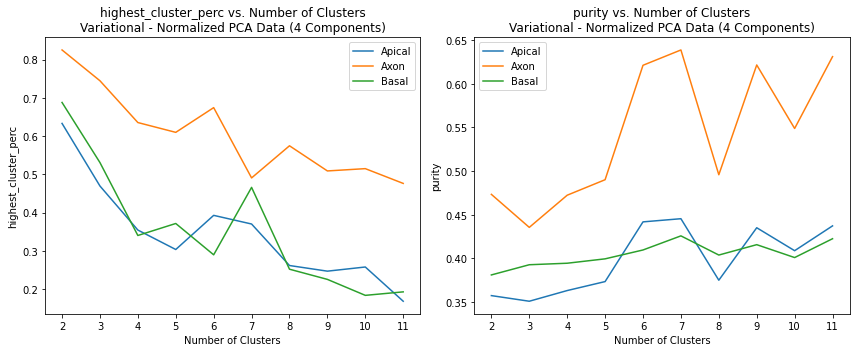

In [92]:
gmm = reload(gmm)
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Variational - Normalized PCA Data (4 Components)",
                 columns_picked = None,
                 possible_K = np.arange(2,12),
                 apply_normalization=True,
                 apply_pca=True,
                  n_components_pca=4,
                 model_type = "variational"
                
                )

In [94]:
vgmm.mu.shape

(11, 4)

Applying Normalization
Applying pca with 4 components
n_components = 4
whiten = True
---- Using sklearn method ----
Explained Variance = [0.21069952 0.34010453 0.45543247 0.53322505]


<Figure size 432x288 with 0 Axes>

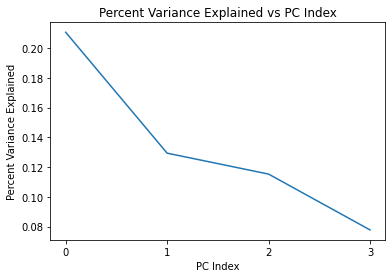

# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


In [36]:
from gmm import *
df = copy.copy(df_filtered)


apply_normalization = True
apply_pca = True
verbose = True
n_components_pca = 4
pca_whiten = True
plot_sqrt_eigvals = False

# Scaling the Data
if apply_normalization:
    if verbose:
        print(f"Applying Normalization")

    scaler_obj = StandardScaler()
    df_data_scaled = scaler_obj.fit_transform(df)

    #df_data_reversed = scaler.inverse_transform(df_data_scaled,copy=True)

    
    data_df_normalized = pd.DataFrame(df_data_scaled)
    #add on the columns
    data_df_normalized.columns = df.columns
    df = data_df_normalized
else:
    scaler_obj = None

# Applying pca to the data
if apply_pca:

    if n_components_pca is None:
        n_components_pca=len(columns_picked)

    if verbose:
        print(f"Applying pca with {n_components_pca} components")

    data_analyzed = dr.pca_analysis(df.to_numpy(),
                                n_components=n_components_pca,
                                whiten=pca_whiten,
                                plot_sqrt_eigvals=plot_sqrt_eigvals)

    if verbose:
        print(f'Explained Variance = {data_analyzed["percent_variance_explained_up_to_n_comp"]}')
        dr.plot_variance_explained(data_analyzed)

    df_pca = pd.DataFrame(data_analyzed["data_proj"])
    df_pca.columns = [f"PC_{j}" for j in range(n_components_pca)]
    df = df_pca

    pca_obj = data_analyzed["pca_obj"]

else:
    pca_obj = None



# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 
if verbose:
    print(f"# -------- Part 1: GMM clustering with different Number of Clusters ----------- # ")

X_train = df